In [13]:
from collections import Counter
from functools import partial
import copy

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from skmultilearn.model_selection import iterative_train_test_split
import spacy
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split

sns.set(rc={'figure.figsize':(10,10)})
SEED = 42

In [14]:
def set_seed(seed):
    """
    Fixa semente aleatória para garantir que os resultados possam ser reproduzidos
    """
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    np.random.seed(seed)
    random.seed(seed)
    
def tokenize (text, tok):
    return [token.text for token in tok.tokenizer(text)]

def encode_sentence(text, vocab2index, tok, N=1000):
    # tokenize text
    tokenized = tokenize(text, tok)
    # generate vector of size N filled with zeros
    encoded = np.zeros(N, dtype=int)
    # get encode for each word in text, if word not in vocab2index return UNK encode = 1
    enc1 = np.array([vocab2index.get(word, vocab2index["UNK"]) for word in tokenized])
    # sentence length
    length = min(N, len(enc1))
    # if the sentence length is less than N, the extra spaces will be filled with zeros.
    encoded[:length] = enc1[:length]
    return encoded, length

In [15]:
class load_data(torch.utils.data.Dataset):
    """
    Classe auxiliar para utilização do DataLoader
    """
    def __init__(self, X, Y):
        self.X = X
        self.y = Y
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        # word_embedding, label, document length
        return torch.from_numpy(self.X[idx][-1][0].astype(np.int32)), self.y[idx], self.X[idx][-1][1], self.X[idx][0], self.X[idx][1]

In [16]:
def split_data(df_data, fold):
    X = df_data.loc[df_data['fold'] == fold, ["city", "doc_id","four_pages_encoded"]].values
    y = df_data.loc[df_data['fold'] == fold, 'label_int'].values
    
    return X, y

def encode_data(df_data, config):
    tok = spacy.load('pt_core_news_sm')

    # count frequency of each word    
    counts = Counter()
    for index, row in df_data.loc[df_data['fold']=="train"].iterrows():
        counts.update(tokenize(row['four_pages_processed'], tok))

    #creating vocabulary
    vocab2index = {"":0, "UNK":1}
    words = ["", "UNK"]
    for word in counts:
        vocab2index[word] = len(words)
        words.append(word)
        
    vocab_size = len(words)

    # encoding
    df_data['four_pages_encoded'] = None
    df_data.loc[df_data['fold'] == 'train','four_pages_encoded'] = df_data.loc[df_data['fold'] == 'train','four_pages_processed'].apply(lambda x: np.array(encode_sentence(x,vocab2index, tok, config["num_terms"] )))
    df_data.loc[df_data['fold'] == 'val','four_pages_encoded'] = df_data.loc[df_data['fold'] == 'val','four_pages_processed'].apply(lambda x: np.array(encode_sentence(x,vocab2index, tok, config["num_terms"] )))
    df_data.loc[df_data['fold'] == 'test','four_pages_encoded'] = df_data.loc[df_data['fold'] == 'test','four_pages_processed'].apply(lambda x: np.array(encode_sentence(x,vocab2index, tok, config["num_terms"] )))
    
    return df_data, vocab_size, vocab2index

In [17]:
def calculate_metrics(y_true, y_pred):
    f1_macro = f1_score(y_true, y_pred, average='macro')
    f1_weighted = f1_score(y_true, y_pred, average='weighted')
    acc = accuracy_score(y_true, y_pred)
    
    return acc, f1_macro, f1_weighted

In [18]:
import torch
from torch import nn
from typing import List
import os
import json



class LSTM(nn.Module):
    """
    Bidirectional LSTM running over word embeddings.
    """
    def __init__(self, embedding_matrix, word_embedding_dimension: int, hidden_dim: int, num_layers: int = 1, num_classes: int = 13, vocab_size: int = 0, dropout: float = 0, bidirectional: bool = True):
        nn.Module.__init__(self)
        self.config_keys = ['word_embedding_dimension', 'hidden_dim', 'num_layers', 'dropout', 'bidirectional']
        self.word_embedding_dimension = word_embedding_dimension
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.dropout = dropout
        self.bidirectional = bidirectional
        self.vocab_size = vocab_size

        self.embeddings_dimension = hidden_dim
        if self.bidirectional:
            self.embeddings_dimension *= 2
            
        self.embeddings = nn.Embedding(vocab_size, word_embedding_dimension, padding_idx=0)
        self.embeddings.weight=nn.Parameter(torch.tensor(embedding_matrix,dtype=torch.float32))
        self.embeddings.weight.requires_grad=False
        self.dropout = nn.Dropout(dropout)
        self.encoder = nn.LSTM(word_embedding_dimension, int(word_embedding_dimension/2), num_layers=num_layers, dropout=dropout, bidirectional=bidirectional, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(int(word_embedding_dimension/2), num_classes)
        #self.linear = nn.Linear(self.hidden_dim*4 , 64)
        #self.relu = nn.ReLU()
        #self.dropout = nn.Dropout(dropout)
        #self.out = nn.Linear(64, num_classes)
        
        #self.dropout = nn.Dropout(dropout)
        #self.linear = nn.Linear(hidden_dim, num_classes)

    def forward(self, features, sentence_length):
        #token_embeddings = features['token_embeddings']
        #sentence_lengths = torch.clamp(features['sentence_lengths'], min=1)
        x = self.embeddings(features)
        x = self.dropout(x)
        #packed = nn.utils.rnn.pack_padded_sequence(x, sentence_length, batch_first=True, enforce_sorted=False)
        out_pack, (ht, ct) = self.encoder(x)
        ht[-1] = self.dropout(ht[-1])
        out = self.linear(ht[-1])
        #avg_pool = torch.mean(out_pack, 1)
        #max_pool, _ = torch.max(out_pack, 1)
        #conc = torch.cat(( avg_pool, max_pool), 1)
        #conc = self.relu(self.linear(conc))
        #conc = self.dropout(conc)
        #out = self.out(conc)
        return out

    def get_word_embedding_dimension(self) -> int:
        return self.embeddings_dimension

    def tokenize(self, text: str) -> List[int]:
        raise NotImplementedError()

    def save(self, output_path: str):
        with open(os.path.join(output_path, 'lstm_config.json'), 'w') as fOut:
            json.dump(self.get_config_dict(), fOut, indent=2)

        torch.save(self.state_dict(), os.path.join(output_path, 'pytorch_model.bin'))

    def get_config_dict(self):
        return {key: self.__dict__[key] for key in self.config_keys}

    @staticmethod
    def load(input_path: str):
        with open(os.path.join(input_path, 'lstm_config.json'), 'r') as fIn:
            config = json.load(fIn)

        weights = torch.load(os.path.join(input_path, 'pytorch_model.bin'))
        model = LSTM(**config)
        model.load_state_dict(weights)
        return model

In [19]:
def data_load(config, df_data):
    # Split data
    X_train, y_train = split_data(df_data, "train")
    X_val, y_val = split_data(df_data, "val")
    X_test, y_test = split_data(df_data, "test")
    
    # Load dataset
    train_set = load_data(X_train, y_train)
    val_set = load_data(X_val, y_val)
    test_set = load_data(X_test, y_test)
    
    data_loaders = dict()

    data_loaders["train"] = torch.utils.data.DataLoader(
        train_set,
        batch_size=int(config["batch_size"]),
        shuffle=True,
        num_workers=8)
    data_loaders["val"] = torch.utils.data.DataLoader(
        val_set,
        batch_size=int(config["batch_size"]),
        shuffle=False,
        num_workers=8)
    data_loaders["test"] = torch.utils.data.DataLoader(
        test_set,
        batch_size=int(config["batch_size"]),
        shuffle=False,
        num_workers=8)
    
    return data_loaders

In [20]:
def plot_confusion_matrix(y_pred, y_true, fold, labels_dict):
    ticks = copy.deepcopy(y_pred)
    ticks.extend(y_true)
    print(set(ticks))
    print(labels_dict)
    ticks = [labels_dict[tick] for tick in set(ticks)]
    
    cm = sns.heatmap(
        confusion_matrix(y_true, y_pred,normalize="true"),
        annot=True,
        center=0,
        vmin=0,
        vmax=1,
        square=True,
        fmt=".2f",
        xticklabels=ticks,
        yticklabels=ticks,
    )
    plt.yticks(rotation=0)
    img_name = "Confusion Matrix - {}".format(fold)
    plt.title(img_name)
    plt.show()

In [21]:
def eval_model(city_t, model, loader, fold=None, labels_dict = None, device="cpu"):
    model.eval()
    criterion = nn.CrossEntropyLoss()

    steps = 0
    sum_loss = 0.0
    y_true = []
    y_pred = []
    cities = []
    docs = []
    with torch.no_grad():
        for data in loader:
            if fold:
                inputs, labels, sentence_length, city, doc_id = data
                cities.extend(city)
                docs.extend(doc_id)
            else:
                inputs, labels, sentence_length, _, _ = data
            inputs, labels = inputs.long().to(device), labels.long().to(device)
            outputs = model(inputs, sentence_length)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)
            
            steps += 1
            sum_loss += loss.cpu().detach().numpy()
            
            y_pred.extend(predicted.cpu().tolist())
            y_true.extend(labels.cpu().tolist())
    
    metrics = [(sum_loss/steps)]
    metrics.extend(calculate_metrics(y_true, y_pred))
    if fold:
        df_predictions = pd.DataFrame({"doc_id": docs, "city": cities, "label": y_true, "pred": y_pred})
        df_predictions['fold'] = fold
        df_predictions.to_csv(f"./lstm_data/results/setup_2/setup_2_{city_t}_{fold}.csv")
        # Plot confusion matrix
        plot_confusion_matrix(y_pred, y_true, fold, labels_dict)
    return metrics

In [22]:
def train_model(city, config, checkpoint_dir=None, data_loaders=None, embedding_matrix = None):
    if not config["patience"]:
        config["patience"] = config["num_epochs"]
    patience_counter = 0
    
    train_loader = data_loaders["train"]
    val_loader = data_loaders["val"]
    
    model = LSTM(
        embedding_matrix = embedding_matrix,
        word_embedding_dimension = config["embedding_dim"], 
        hidden_dim = config["embedding_dim"], 
        num_classes = config["num_classes"], 
        vocab_size = config["vocab_size"],
        num_layers = config["num_layers"], 
        dropout = config["dropout"], 
        bidirectional = True
    )
        
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
    model.to(device)
    
    best_model = copy.deepcopy(model)
    best_loss = float("inf")
    #best_macro = 0.0

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=config["lr"])

    """if checkpoint_dir:
        model_state, optimizer_state = torch.load(
            os.path.join(checkpoint_dir, "checkpoint"))
        model.load_state_dict(model_state)
        optimizer.load_state_dict(optimizer_state)"""
        
    for epoch in range(config["num_epochs"]):  # loop over the dataset multiple times
        print("="*20,"Epoch: {}".format(epoch+1), "="*20)
        model.train()
        training_loss = 0.0
        epoch_steps = 0
        y_pred = []
        y_true = []
        for i, data in enumerate(train_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels, sentence_length, _, _ = data
            inputs, labels = inputs.long().to(device), labels.long().to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs, sentence_length)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            epoch_steps += 1
            training_loss += loss.cpu().detach().numpy()
            
            _, predicted = torch.max(outputs.data, 1)
            
            y_pred.extend(predicted.cpu().tolist())
            y_true.extend(labels.cpu().tolist())
            
        train_metrics = [(training_loss/epoch_steps)]
        train_metrics.extend(calculate_metrics(y_true, y_pred))
        
        print("Train:\n loss %.3f, accuracy %.3f, F1-Macro %.3f, F1-Weighted %.3f" % (
        train_metrics[0], train_metrics[1], train_metrics[2], train_metrics[3]))

        val_metrics = eval_model(city, model, val_loader, device=device)
        print("Val:\n loss %.3f, accuracy %.3f, F1-Macro %.3f, F1-Weighted %.3f \n" % (
        val_metrics[0], val_metrics[1], val_metrics[2], val_metrics[3]))
        
        if val_metrics[0] <= best_loss - 0.001:
            best_loss = val_metrics[0]
            best_model = copy.deepcopy(model)
            best_macro = val_metrics[2]
            patience_counter = 0
            path = os.path.join(checkpoint_dir, "model_setup_2.pth")
            torch.save((model.state_dict(), optimizer.state_dict()), path)
        else:
            patience_counter += 1
            if patience_counter >= config["patience"]:
                print("Model training was stopped early")
                break
    print("Finished Training")
    return best_model

In [23]:
def create_embedding_matrix(word_index,dimension):
    df_emb = pd.read_csv("./lstm_data/embeddings/modelo_w2v_vec600_wd10_ct5_tec1.txt", header=None, sep = " ", index_col=0, skiprows=1)
    #df_emb = pd.read_csv("./lstm_data/skip_s600.txt", header=None, sep = " ", index_col=0, skiprows=1)

    embedding_dict = {key: val.values for key, val in df_emb.T.items()}
    embedding_matrix=np.zeros((len(word_index)+1,dimension))

    for word,index in word_index.items():
        if word in embedding_dict:
            embedding_matrix[index]=embedding_dict[word]
    return embedding_matrix

**** VALIDATION CITY: cristais****


/dados01/workspace/ufmg.f01dcc/py37/lib/python3.7/site-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/dados01/workspace/ufmg.f01dcc/py37/lib/python3.7/site-packages/ipykernel_launcher.py:27: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/dados01/workspace/ufmg.f01dcc/py37/lib/python3.7/site-packages/ipykernel_launcher.py:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to 

==================== Epoch: 1 ====================
Train:
 loss 1.557, accuracy 0.526, F1-Macro 0.217, F1-Weighted 0.453
Val:
 loss 0.759, accuracy 0.786, F1-Macro 0.481, F1-Weighted 0.756 

==================== Epoch: 2 ====================
Train:
 loss 0.504, accuracy 0.873, F1-Macro 0.625, F1-Weighted 0.858
Val:
 loss 0.452, accuracy 0.857, F1-Macro 0.592, F1-Weighted 0.848 

==================== Epoch: 3 ====================
Train:
 loss 0.372, accuracy 0.895, F1-Macro 0.658, F1-Weighted 0.883
Val:
 loss 0.393, accuracy 0.886, F1-Macro 0.668, F1-Weighted 0.872 

==================== Epoch: 4 ====================
Train:
 loss 0.286, accuracy 0.921, F1-Macro 0.734, F1-Weighted 0.911
Val:
 loss 0.323, accuracy 0.917, F1-Macro 0.737, F1-Weighted 0.907 

==================== Epoch: 5 ====================
Train:
 loss 0.220, accuracy 0.938, F1-Macro 0.775, F1-Weighted 0.931
Val:
 loss 0.292, accuracy 0.927, F1-Macro 0.751, F1-Weighted 0.917 

==================== Epoch: 6 ===============

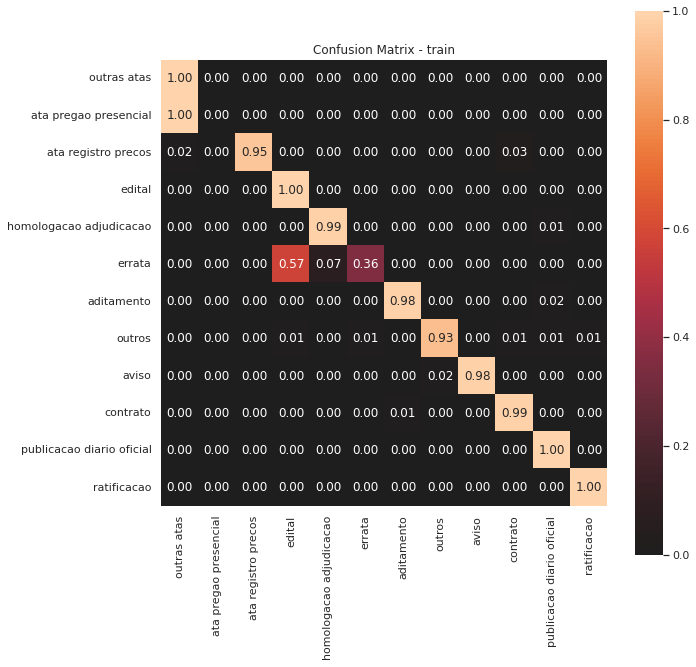

Train:
 loss 0.112, accuracy 0.970, F1-Macro 0.844, F1-Weighted 0.966
{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12}
{0: 'ata dispensa licitacao', 1: 'outras atas', 2: 'ata pregao presencial', 3: 'ata registro precos', 4: 'edital', 5: 'homologacao adjudicacao', 6: 'errata', 7: 'aditamento', 8: 'outros', 9: 'aviso', 10: 'contrato', 11: 'publicacao diario oficial', 12: 'ratificacao'}


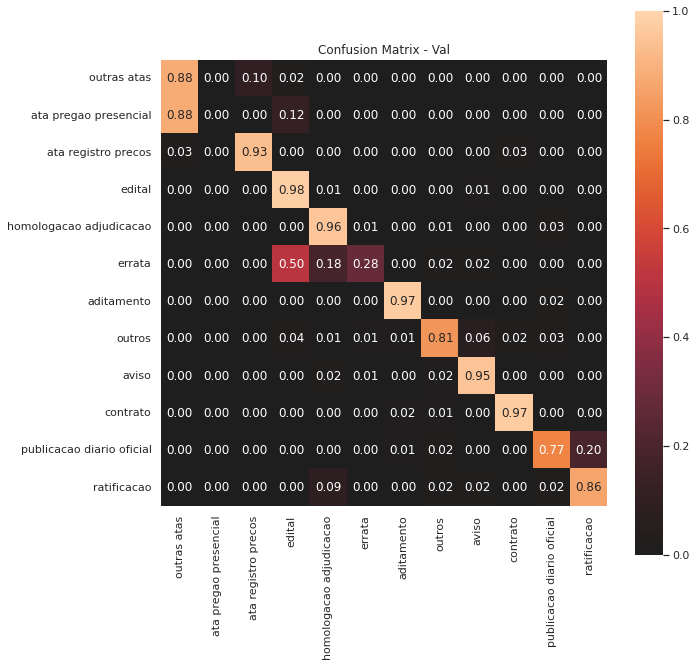

Val:
 loss 0.262, accuracy 0.929, F1-Macro 0.776, F1-Weighted 0.924
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12}
{0: 'ata dispensa licitacao', 1: 'outras atas', 2: 'ata pregao presencial', 3: 'ata registro precos', 4: 'edital', 5: 'homologacao adjudicacao', 6: 'errata', 7: 'aditamento', 8: 'outros', 9: 'aviso', 10: 'contrato', 11: 'publicacao diario oficial', 12: 'ratificacao'}


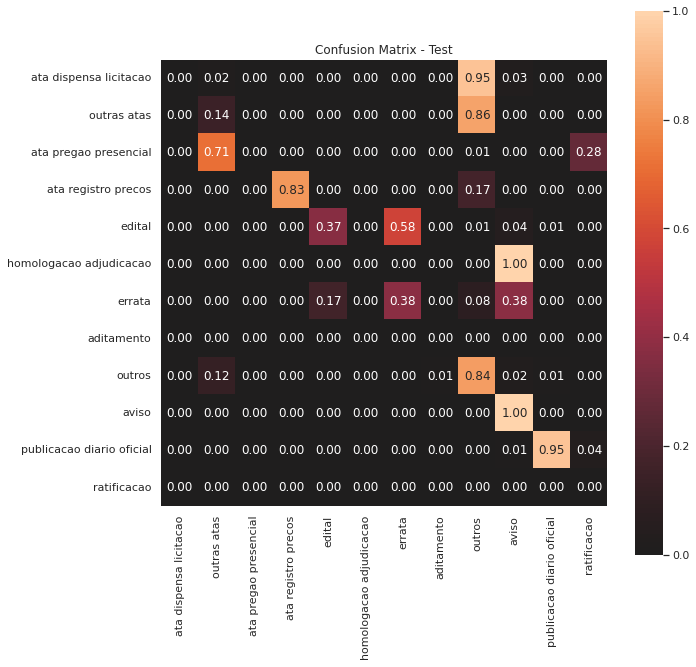

Test:
 loss 2.610, accuracy 0.415, F1-Macro 0.268, F1-Weighted 0.443
**** VALIDATION CITY: pirapetinga****


/dados01/workspace/ufmg.f01dcc/py37/lib/python3.7/site-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/dados01/workspace/ufmg.f01dcc/py37/lib/python3.7/site-packages/ipykernel_launcher.py:27: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/dados01/workspace/ufmg.f01dcc/py37/lib/python3.7/site-packages/ipykernel_launcher.py:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to 

==================== Epoch: 1 ====================
Train:
 loss 1.458, accuracy 0.577, F1-Macro 0.266, F1-Weighted 0.510
Val:
 loss 0.792, accuracy 0.805, F1-Macro 0.525, F1-Weighted 0.768 

==================== Epoch: 2 ====================
Train:
 loss 0.612, accuracy 0.849, F1-Macro 0.629, F1-Weighted 0.828
Val:
 loss 0.565, accuracy 0.835, F1-Macro 0.641, F1-Weighted 0.803 

==================== Epoch: 3 ====================
Train:
 loss 0.360, accuracy 0.912, F1-Macro 0.754, F1-Weighted 0.897
Val:
 loss 0.331, accuracy 0.921, F1-Macro 0.771, F1-Weighted 0.905 

==================== Epoch: 4 ====================
Train:
 loss 0.250, accuracy 0.940, F1-Macro 0.835, F1-Weighted 0.929
Val:
 loss 0.350, accuracy 0.924, F1-Macro 0.837, F1-Weighted 0.914 

==================== Epoch: 5 ====================
Train:
 loss 0.230, accuracy 0.946, F1-Macro 0.863, F1-Weighted 0.938
Val:
 loss 0.302, accuracy 0.927, F1-Macro 0.831, F1-Weighted 0.918 

==================== Epoch: 6 ===============

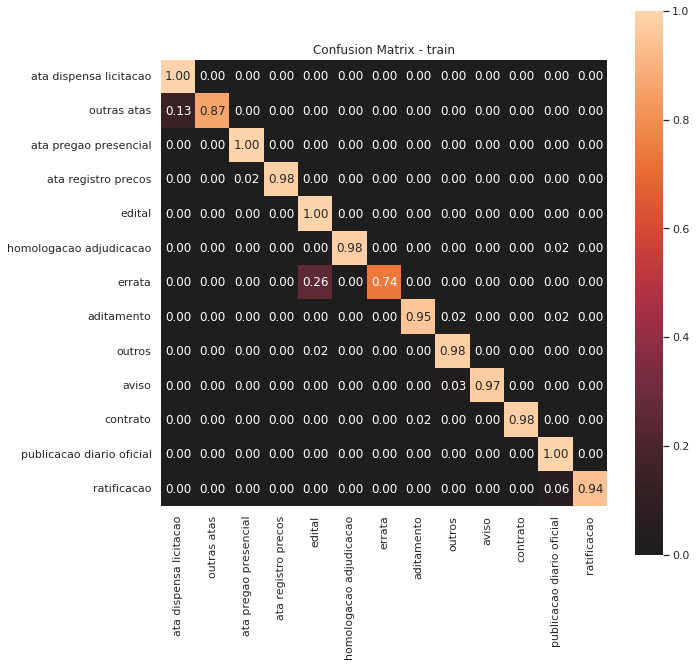

Train:
 loss 0.078, accuracy 0.982, F1-Macro 0.963, F1-Weighted 0.981
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12}
{0: 'ata dispensa licitacao', 1: 'outras atas', 2: 'ata pregao presencial', 3: 'ata registro precos', 4: 'edital', 5: 'homologacao adjudicacao', 6: 'errata', 7: 'aditamento', 8: 'outros', 9: 'aviso', 10: 'contrato', 11: 'publicacao diario oficial', 12: 'ratificacao'}


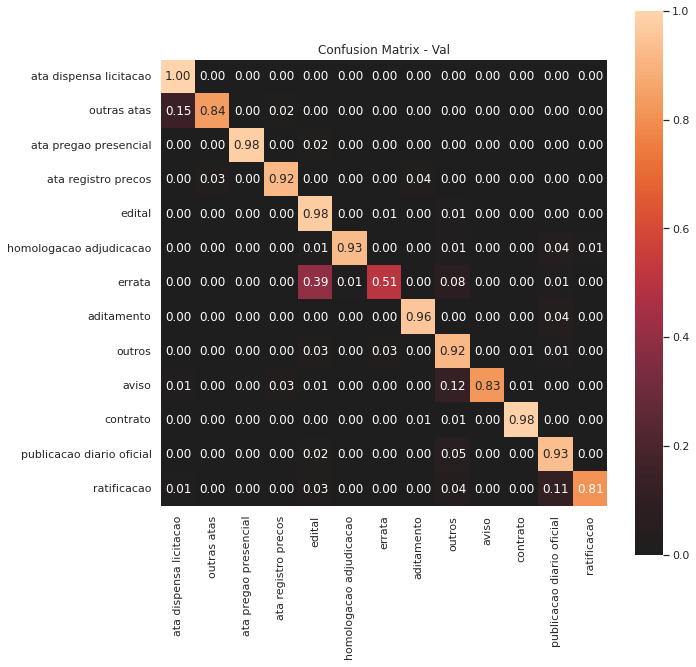

Val:
 loss 0.267, accuracy 0.942, F1-Macro 0.897, F1-Weighted 0.941
{1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12}
{0: 'ata dispensa licitacao', 1: 'outras atas', 2: 'ata pregao presencial', 3: 'ata registro precos', 4: 'edital', 5: 'homologacao adjudicacao', 6: 'errata', 7: 'aditamento', 8: 'outros', 9: 'aviso', 10: 'contrato', 11: 'publicacao diario oficial', 12: 'ratificacao'}


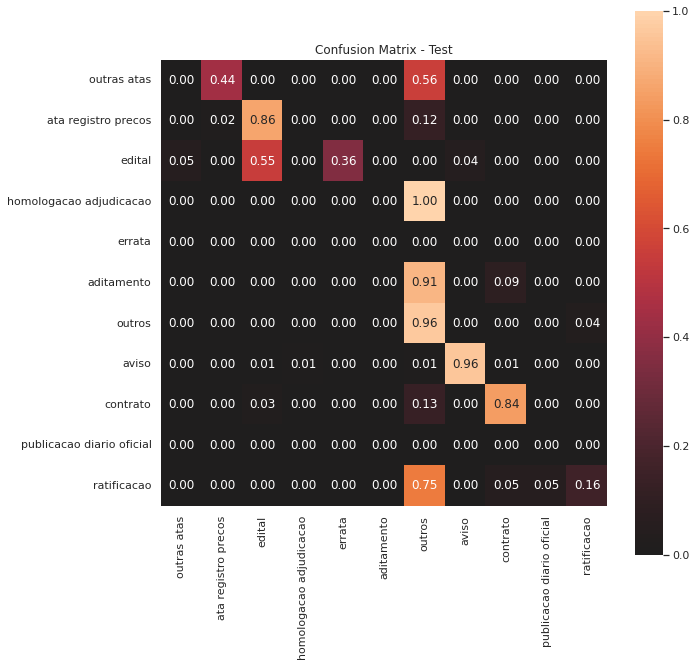

Test:
 loss 3.965, accuracy 0.470, F1-Macro 0.273, F1-Weighted 0.413
**** VALIDATION CITY: sao_bento_abade****


/dados01/workspace/ufmg.f01dcc/py37/lib/python3.7/site-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/dados01/workspace/ufmg.f01dcc/py37/lib/python3.7/site-packages/ipykernel_launcher.py:27: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/dados01/workspace/ufmg.f01dcc/py37/lib/python3.7/site-packages/ipykernel_launcher.py:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to 

==================== Epoch: 1 ====================
Train:
 loss 1.455, accuracy 0.550, F1-Macro 0.292, F1-Weighted 0.487
Val:
 loss 0.817, accuracy 0.749, F1-Macro 0.492, F1-Weighted 0.713 

==================== Epoch: 2 ====================
Train:
 loss 0.497, accuracy 0.854, F1-Macro 0.695, F1-Weighted 0.842
Val:
 loss 0.447, accuracy 0.877, F1-Macro 0.666, F1-Weighted 0.859 

==================== Epoch: 3 ====================
Train:
 loss 0.361, accuracy 0.909, F1-Macro 0.767, F1-Weighted 0.899
Val:
 loss 0.311, accuracy 0.923, F1-Macro 0.813, F1-Weighted 0.917 

==================== Epoch: 4 ====================
Train:
 loss 0.245, accuracy 0.936, F1-Macro 0.831, F1-Weighted 0.929
Val:
 loss 0.260, accuracy 0.941, F1-Macro 0.851, F1-Weighted 0.934 

==================== Epoch: 5 ====================
Train:
 loss 0.156, accuracy 0.961, F1-Macro 0.889, F1-Weighted 0.957
Val:
 loss 0.238, accuracy 0.948, F1-Macro 0.880, F1-Weighted 0.945 

==================== Epoch: 6 ===============

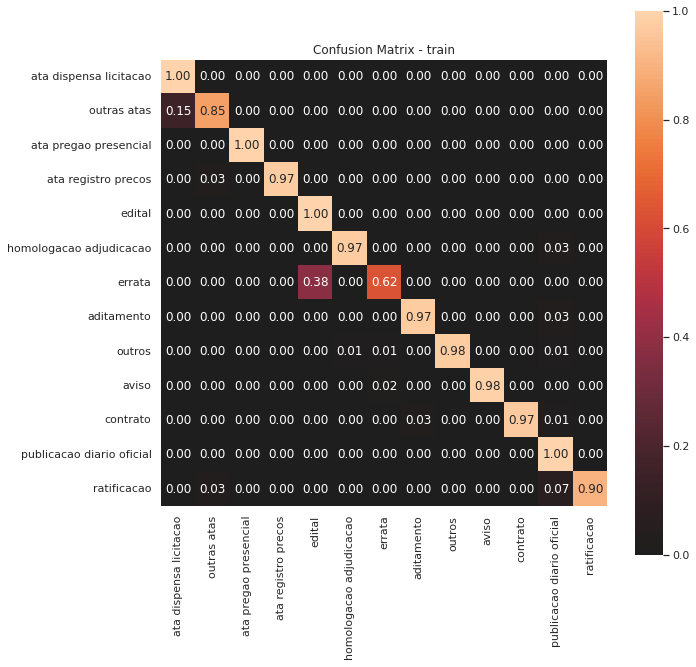

Train:
 loss 0.097, accuracy 0.976, F1-Macro 0.941, F1-Weighted 0.976
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12}
{0: 'ata dispensa licitacao', 1: 'outras atas', 2: 'ata pregao presencial', 3: 'ata registro precos', 4: 'edital', 5: 'homologacao adjudicacao', 6: 'errata', 7: 'aditamento', 8: 'outros', 9: 'aviso', 10: 'contrato', 11: 'publicacao diario oficial', 12: 'ratificacao'}


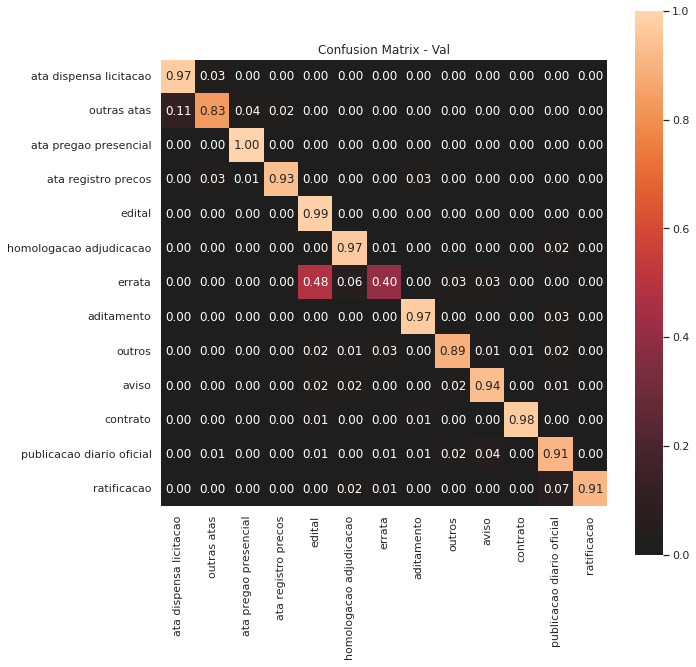

Val:
 loss 0.223, accuracy 0.951, F1-Macro 0.898, F1-Weighted 0.950
{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12}
{0: 'ata dispensa licitacao', 1: 'outras atas', 2: 'ata pregao presencial', 3: 'ata registro precos', 4: 'edital', 5: 'homologacao adjudicacao', 6: 'errata', 7: 'aditamento', 8: 'outros', 9: 'aviso', 10: 'contrato', 11: 'publicacao diario oficial', 12: 'ratificacao'}


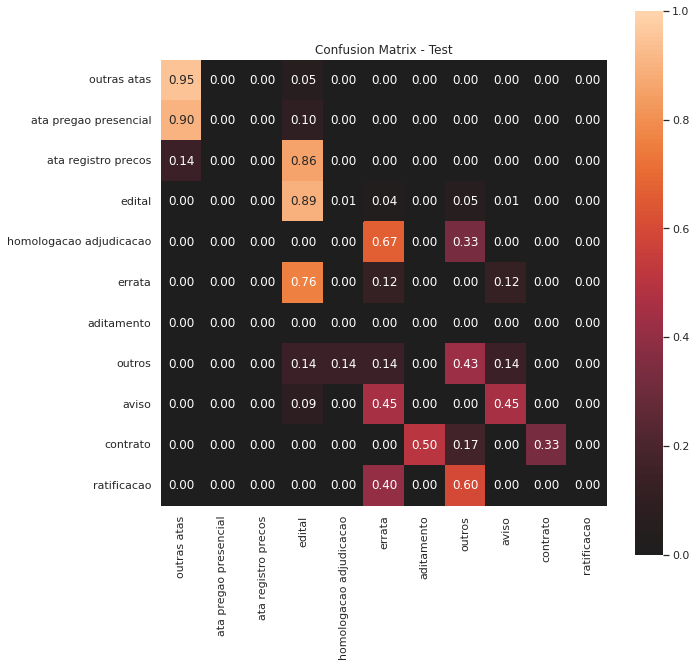

Test:
 loss 1.416, accuracy 0.651, F1-Macro 0.262, F1-Weighted 0.607
**** VALIDATION CITY: coqueiral****


/dados01/workspace/ufmg.f01dcc/py37/lib/python3.7/site-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/dados01/workspace/ufmg.f01dcc/py37/lib/python3.7/site-packages/ipykernel_launcher.py:27: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/dados01/workspace/ufmg.f01dcc/py37/lib/python3.7/site-packages/ipykernel_launcher.py:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to 

==================== Epoch: 1 ====================
Train:
 loss 1.608, accuracy 0.541, F1-Macro 0.186, F1-Weighted 0.467
Val:
 loss 1.008, accuracy 0.700, F1-Macro 0.340, F1-Weighted 0.643 

==================== Epoch: 2 ====================
Train:
 loss 0.723, accuracy 0.785, F1-Macro 0.526, F1-Weighted 0.761
Val:
 loss 0.566, accuracy 0.828, F1-Macro 0.599, F1-Weighted 0.806 

==================== Epoch: 3 ====================
Train:
 loss 0.380, accuracy 0.896, F1-Macro 0.724, F1-Weighted 0.883
Val:
 loss 0.380, accuracy 0.899, F1-Macro 0.736, F1-Weighted 0.887 

==================== Epoch: 4 ====================
Train:
 loss 0.257, accuracy 0.932, F1-Macro 0.817, F1-Weighted 0.923
Val:
 loss 0.274, accuracy 0.932, F1-Macro 0.807, F1-Weighted 0.923 

==================== Epoch: 5 ====================
Train:
 loss 0.222, accuracy 0.941, F1-Macro 0.848, F1-Weighted 0.937
Val:
 loss 0.291, accuracy 0.936, F1-Macro 0.805, F1-Weighted 0.924 

==================== Epoch: 6 ===============

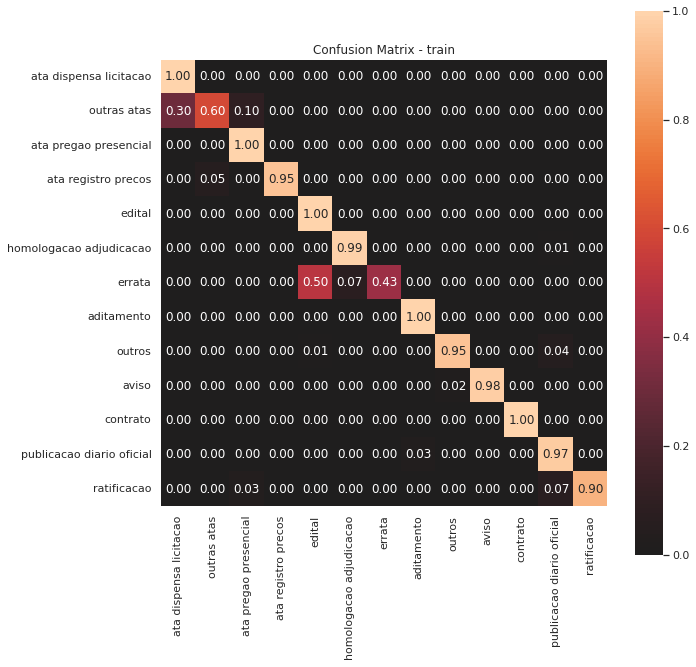

Train:
 loss 0.100, accuracy 0.970, F1-Macro 0.920, F1-Weighted 0.968
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12}
{0: 'ata dispensa licitacao', 1: 'outras atas', 2: 'ata pregao presencial', 3: 'ata registro precos', 4: 'edital', 5: 'homologacao adjudicacao', 6: 'errata', 7: 'aditamento', 8: 'outros', 9: 'aviso', 10: 'contrato', 11: 'publicacao diario oficial', 12: 'ratificacao'}


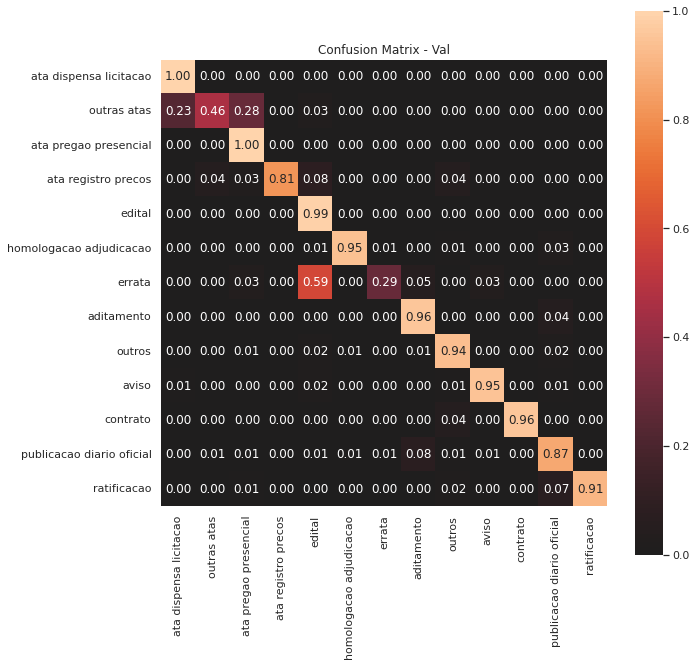

Val:
 loss 0.227, accuracy 0.945, F1-Macro 0.867, F1-Weighted 0.941
{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12}
{0: 'ata dispensa licitacao', 1: 'outras atas', 2: 'ata pregao presencial', 3: 'ata registro precos', 4: 'edital', 5: 'homologacao adjudicacao', 6: 'errata', 7: 'aditamento', 8: 'outros', 9: 'aviso', 10: 'contrato', 11: 'publicacao diario oficial', 12: 'ratificacao'}


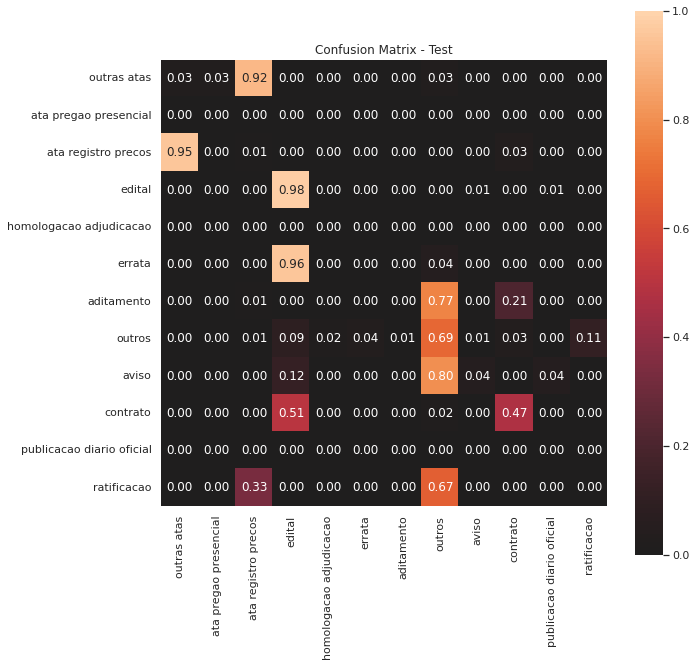

Test:
 loss 2.273, accuracy 0.425, F1-Macro 0.153, F1-Weighted 0.379
**** VALIDATION CITY: passa_vinte****


/dados01/workspace/ufmg.f01dcc/py37/lib/python3.7/site-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/dados01/workspace/ufmg.f01dcc/py37/lib/python3.7/site-packages/ipykernel_launcher.py:27: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/dados01/workspace/ufmg.f01dcc/py37/lib/python3.7/site-packages/ipykernel_launcher.py:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to 

==================== Epoch: 1 ====================
Train:
 loss 1.597, accuracy 0.550, F1-Macro 0.269, F1-Weighted 0.464
Val:
 loss 1.086, accuracy 0.632, F1-Macro 0.340, F1-Weighted 0.540 

==================== Epoch: 2 ====================
Train:
 loss 0.691, accuracy 0.799, F1-Macro 0.591, F1-Weighted 0.777
Val:
 loss 0.472, accuracy 0.876, F1-Macro 0.657, F1-Weighted 0.859 

==================== Epoch: 3 ====================
Train:
 loss 0.388, accuracy 0.902, F1-Macro 0.781, F1-Weighted 0.892
Val:
 loss 0.346, accuracy 0.913, F1-Macro 0.776, F1-Weighted 0.901 

==================== Epoch: 4 ====================
Train:
 loss 0.265, accuracy 0.937, F1-Macro 0.840, F1-Weighted 0.928
Val:
 loss 0.257, accuracy 0.938, F1-Macro 0.857, F1-Weighted 0.930 

==================== Epoch: 5 ====================
Train:
 loss 0.194, accuracy 0.953, F1-Macro 0.885, F1-Weighted 0.946
Val:
 loss 0.240, accuracy 0.944, F1-Macro 0.877, F1-Weighted 0.939 

==================== Epoch: 6 ===============

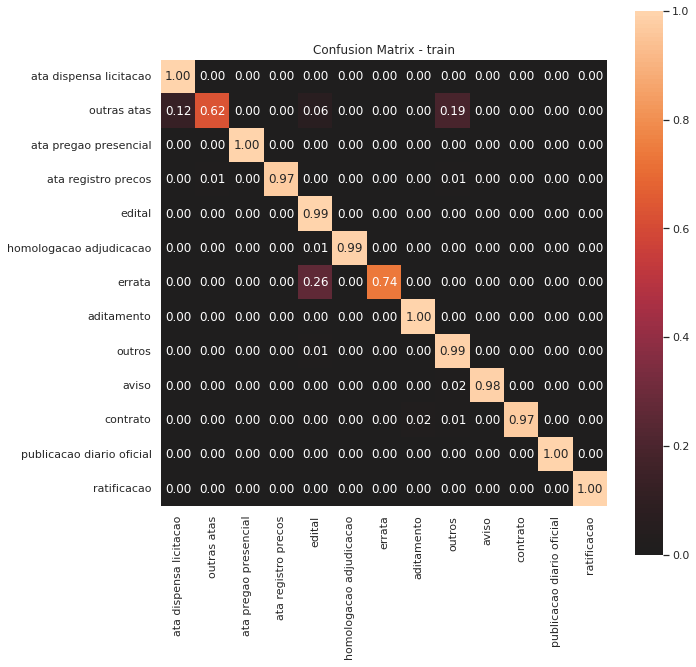

Train:
 loss 0.074, accuracy 0.979, F1-Macro 0.954, F1-Weighted 0.978
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12}
{0: 'ata dispensa licitacao', 1: 'outras atas', 2: 'ata pregao presencial', 3: 'ata registro precos', 4: 'edital', 5: 'homologacao adjudicacao', 6: 'errata', 7: 'aditamento', 8: 'outros', 9: 'aviso', 10: 'contrato', 11: 'publicacao diario oficial', 12: 'ratificacao'}


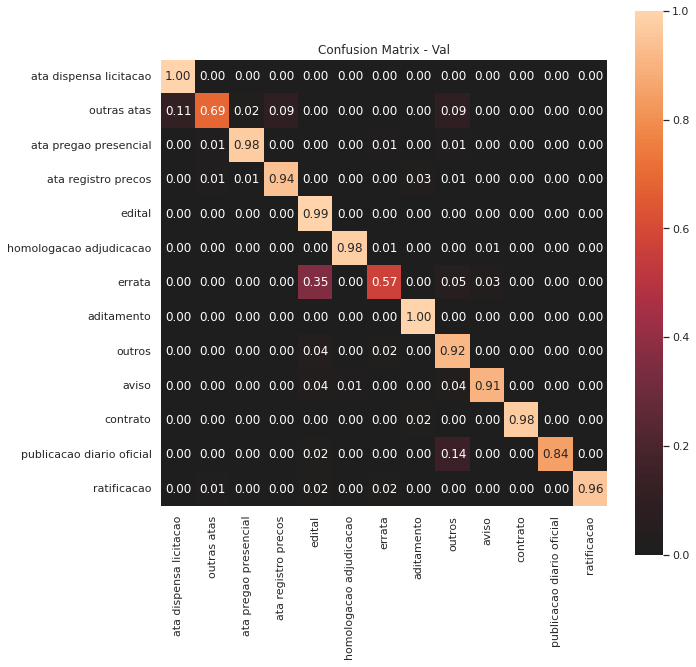

Val:
 loss 0.183, accuracy 0.958, F1-Macro 0.918, F1-Weighted 0.957
{0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12}
{0: 'ata dispensa licitacao', 1: 'outras atas', 2: 'ata pregao presencial', 3: 'ata registro precos', 4: 'edital', 5: 'homologacao adjudicacao', 6: 'errata', 7: 'aditamento', 8: 'outros', 9: 'aviso', 10: 'contrato', 11: 'publicacao diario oficial', 12: 'ratificacao'}


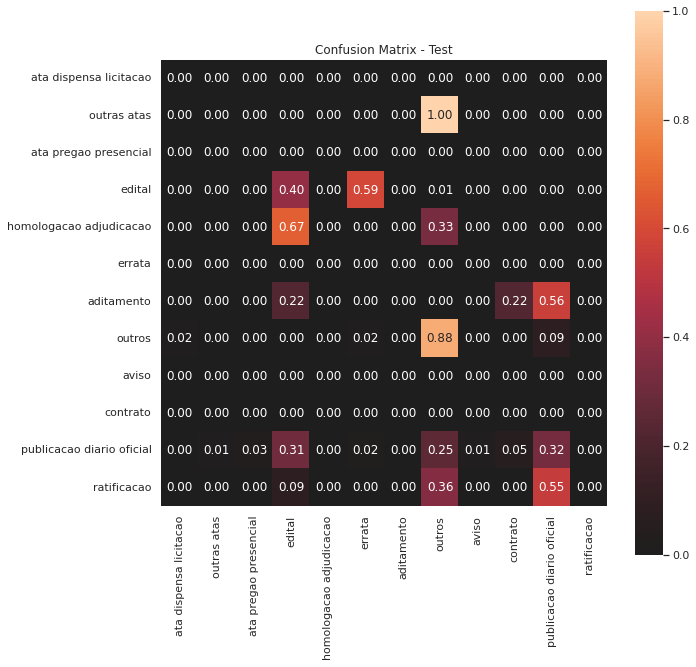

Test:
 loss 1.894, accuracy 0.423, F1-Macro 0.135, F1-Weighted 0.458
**** VALIDATION CITY: itamarati****


/dados01/workspace/ufmg.f01dcc/py37/lib/python3.7/site-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/dados01/workspace/ufmg.f01dcc/py37/lib/python3.7/site-packages/ipykernel_launcher.py:27: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/dados01/workspace/ufmg.f01dcc/py37/lib/python3.7/site-packages/ipykernel_launcher.py:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to 

==================== Epoch: 1 ====================
Train:
 loss 1.412, accuracy 0.575, F1-Macro 0.308, F1-Weighted 0.522
Val:
 loss 0.672, accuracy 0.858, F1-Macro 0.628, F1-Weighted 0.836 

==================== Epoch: 2 ====================
Train:
 loss 0.495, accuracy 0.875, F1-Macro 0.666, F1-Weighted 0.855
Val:
 loss 0.386, accuracy 0.905, F1-Macro 0.746, F1-Weighted 0.888 

==================== Epoch: 3 ====================
Train:
 loss 0.333, accuracy 0.912, F1-Macro 0.744, F1-Weighted 0.898
Val:
 loss 0.381, accuracy 0.901, F1-Macro 0.743, F1-Weighted 0.889 

==================== Epoch: 4 ====================
Train:
 loss 0.305, accuracy 0.916, F1-Macro 0.769, F1-Weighted 0.906
Val:
 loss 0.436, accuracy 0.888, F1-Macro 0.724, F1-Weighted 0.870 

==================== Epoch: 5 ====================
Train:
 loss 0.284, accuracy 0.931, F1-Macro 0.802, F1-Weighted 0.920
Val:
 loss 0.330, accuracy 0.905, F1-Macro 0.746, F1-Weighted 0.892 

==================== Epoch: 6 ===============

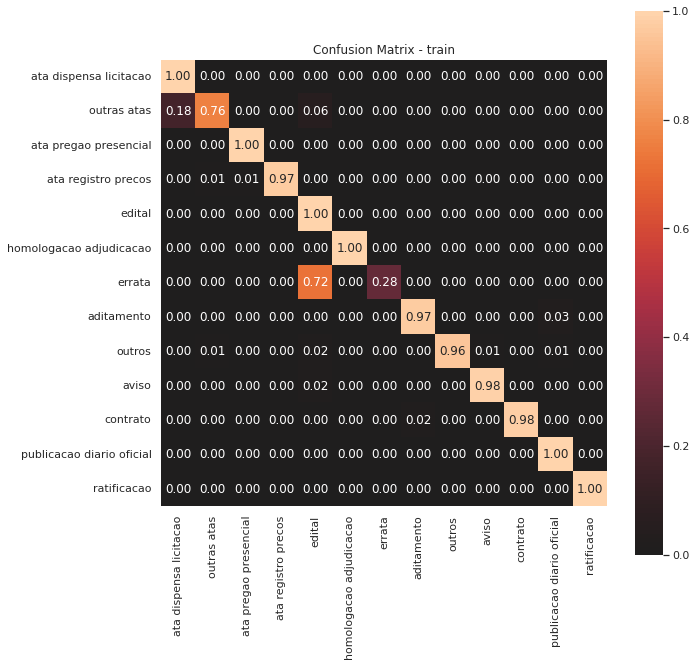

Train:
 loss 0.115, accuracy 0.970, F1-Macro 0.926, F1-Weighted 0.967
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12}
{0: 'ata dispensa licitacao', 1: 'outras atas', 2: 'ata pregao presencial', 3: 'ata registro precos', 4: 'edital', 5: 'homologacao adjudicacao', 6: 'errata', 7: 'aditamento', 8: 'outros', 9: 'aviso', 10: 'contrato', 11: 'publicacao diario oficial', 12: 'ratificacao'}


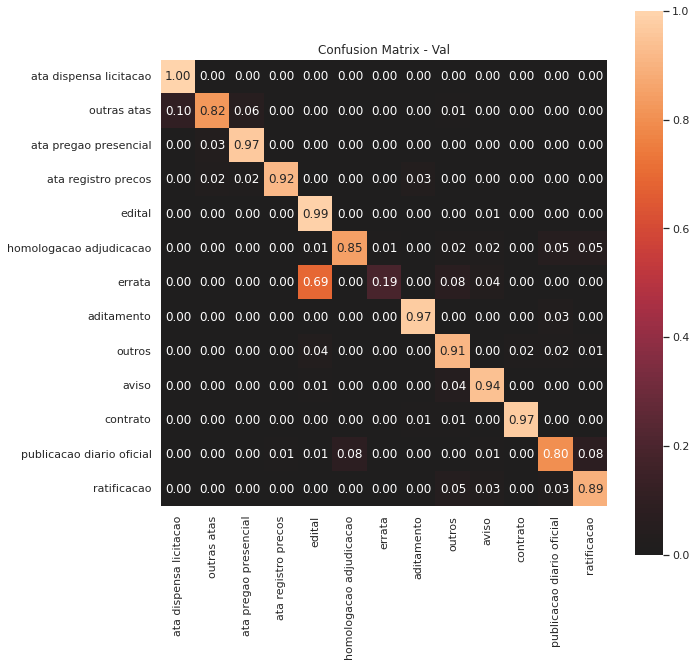

Val:
 loss 0.257, accuracy 0.937, F1-Macro 0.863, F1-Weighted 0.933
{1, 4, 5, 6, 8, 9, 10, 12}
{0: 'ata dispensa licitacao', 1: 'outras atas', 2: 'ata pregao presencial', 3: 'ata registro precos', 4: 'edital', 5: 'homologacao adjudicacao', 6: 'errata', 7: 'aditamento', 8: 'outros', 9: 'aviso', 10: 'contrato', 11: 'publicacao diario oficial', 12: 'ratificacao'}


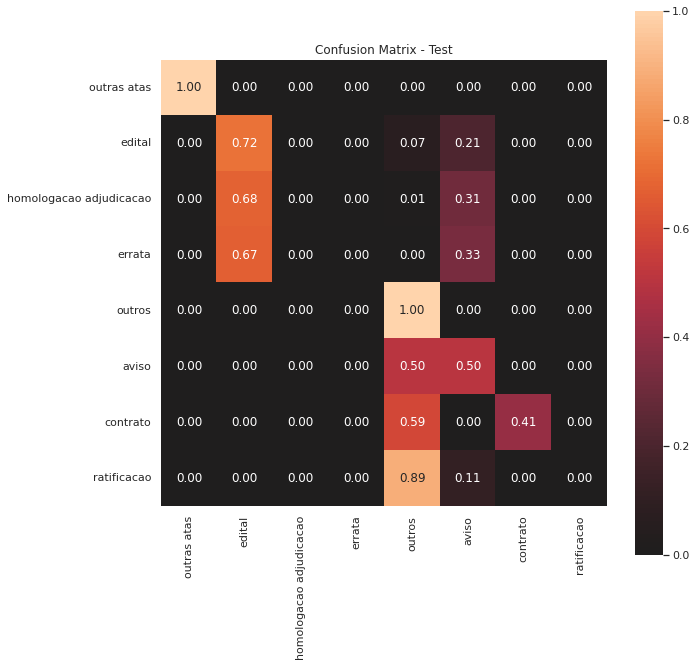

Test:
 loss 3.661, accuracy 0.339, F1-Macro 0.286, F1-Weighted 0.291
**** VALIDATION CITY: arantina****


/dados01/workspace/ufmg.f01dcc/py37/lib/python3.7/site-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/dados01/workspace/ufmg.f01dcc/py37/lib/python3.7/site-packages/ipykernel_launcher.py:27: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/dados01/workspace/ufmg.f01dcc/py37/lib/python3.7/site-packages/ipykernel_launcher.py:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to 

==================== Epoch: 1 ====================
Train:
 loss 1.430, accuracy 0.574, F1-Macro 0.317, F1-Weighted 0.515
Val:
 loss 0.727, accuracy 0.786, F1-Macro 0.501, F1-Weighted 0.751 

==================== Epoch: 2 ====================
Train:
 loss 0.577, accuracy 0.836, F1-Macro 0.664, F1-Weighted 0.824
Val:
 loss 0.443, accuracy 0.899, F1-Macro 0.779, F1-Weighted 0.887 

==================== Epoch: 3 ====================
Train:
 loss 0.349, accuracy 0.903, F1-Macro 0.785, F1-Weighted 0.893
Val:
 loss 0.308, accuracy 0.921, F1-Macro 0.819, F1-Weighted 0.911 

==================== Epoch: 4 ====================
Train:
 loss 0.234, accuracy 0.946, F1-Macro 0.864, F1-Weighted 0.940
Val:
 loss 0.259, accuracy 0.932, F1-Macro 0.836, F1-Weighted 0.925 

==================== Epoch: 5 ====================
Train:
 loss 0.212, accuracy 0.947, F1-Macro 0.878, F1-Weighted 0.943
Val:
 loss 0.297, accuracy 0.923, F1-Macro 0.849, F1-Weighted 0.918 

==================== Epoch: 6 ===============

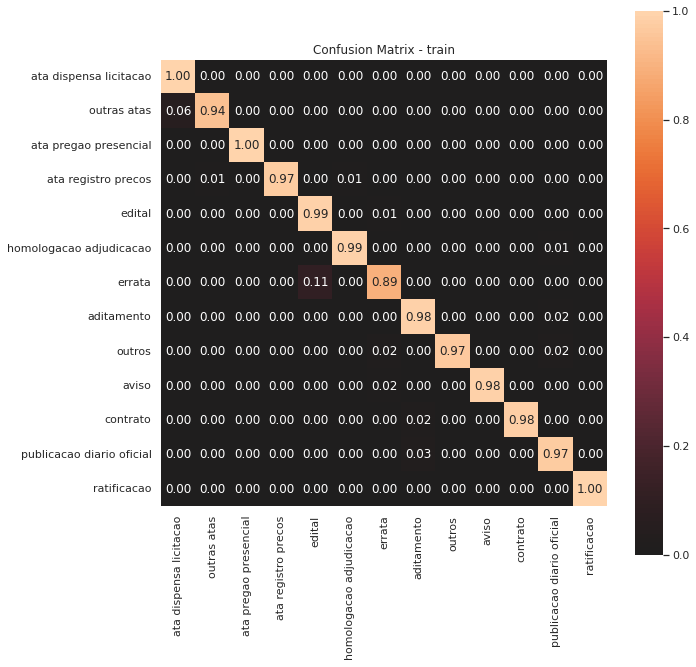

Train:
 loss 0.054, accuracy 0.981, F1-Macro 0.965, F1-Weighted 0.982
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12}
{0: 'ata dispensa licitacao', 1: 'outras atas', 2: 'ata pregao presencial', 3: 'ata registro precos', 4: 'edital', 5: 'homologacao adjudicacao', 6: 'errata', 7: 'aditamento', 8: 'outros', 9: 'aviso', 10: 'contrato', 11: 'publicacao diario oficial', 12: 'ratificacao'}


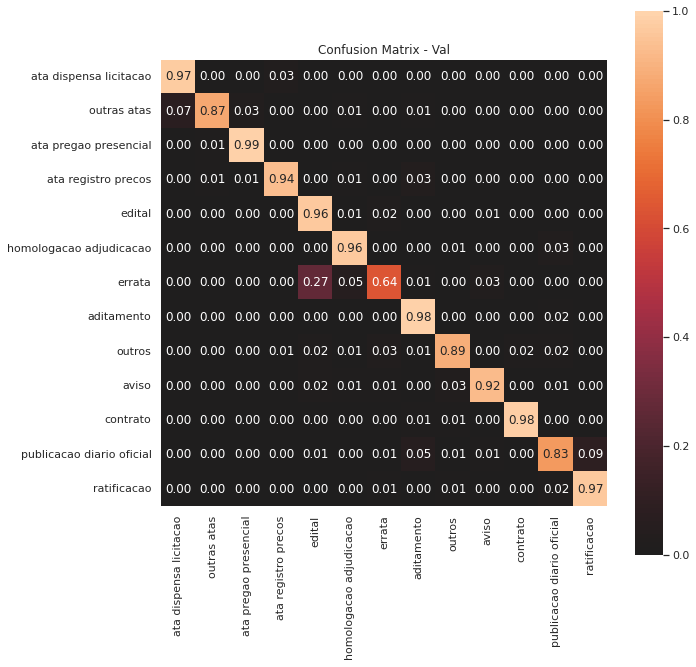

Val:
 loss 0.224, accuracy 0.943, F1-Macro 0.907, F1-Weighted 0.944
{4, 5, 6, 8, 9}
{0: 'ata dispensa licitacao', 1: 'outras atas', 2: 'ata pregao presencial', 3: 'ata registro precos', 4: 'edital', 5: 'homologacao adjudicacao', 6: 'errata', 7: 'aditamento', 8: 'outros', 9: 'aviso', 10: 'contrato', 11: 'publicacao diario oficial', 12: 'ratificacao'}


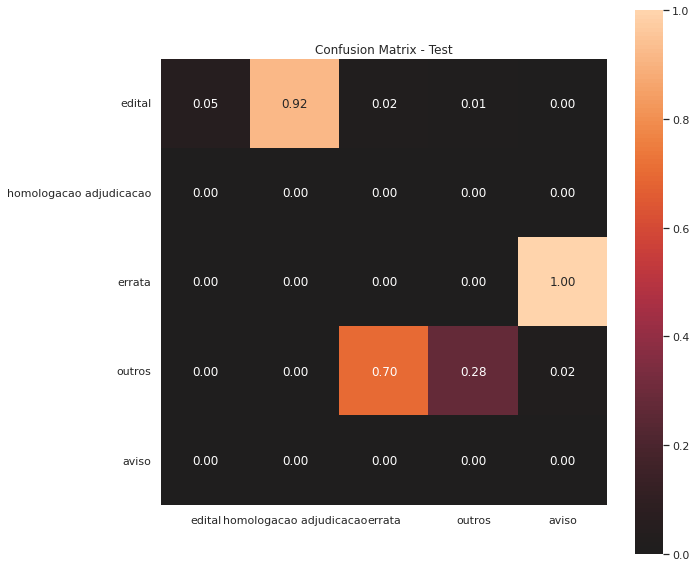

Test:
 loss 4.349, accuracy 0.082, F1-Macro 0.103, F1-Weighted 0.141
**** VALIDATION CITY: ijaci****


/dados01/workspace/ufmg.f01dcc/py37/lib/python3.7/site-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/dados01/workspace/ufmg.f01dcc/py37/lib/python3.7/site-packages/ipykernel_launcher.py:27: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/dados01/workspace/ufmg.f01dcc/py37/lib/python3.7/site-packages/ipykernel_launcher.py:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to 

==================== Epoch: 1 ====================
Train:
 loss 1.536, accuracy 0.521, F1-Macro 0.231, F1-Weighted 0.452
Val:
 loss 0.931, accuracy 0.742, F1-Macro 0.434, F1-Weighted 0.704 

==================== Epoch: 2 ====================
Train:
 loss 0.324, accuracy 0.921, F1-Macro 0.805, F1-Weighted 0.913
Val:
 loss 0.380, accuracy 0.903, F1-Macro 0.802, F1-Weighted 0.896 

==================== Epoch: 5 ====================
Train:
 loss 0.287, accuracy 0.934, F1-Macro 0.844, F1-Weighted 0.927
Val:
 loss 0.334, accuracy 0.910, F1-Macro 0.816, F1-Weighted 0.904 

==================== Epoch: 6 ====================
Train:
 loss 0.257, accuracy 0.933, F1-Macro 0.831, F1-Weighted 0.925
Val:
 loss 0.265, accuracy 0.933, F1-Macro 0.857, F1-Weighted 0.928 

==================== Epoch: 7 ====================
Train:
 loss 0.185, accuracy 0.951, F1-Macro 0.875, F1-Weighted 0.948
Val:
 loss 0.248, accuracy 0.932, F1-Macro 0.856, F1-Weighted 0.931 

==================== Epoch: 8 ===============

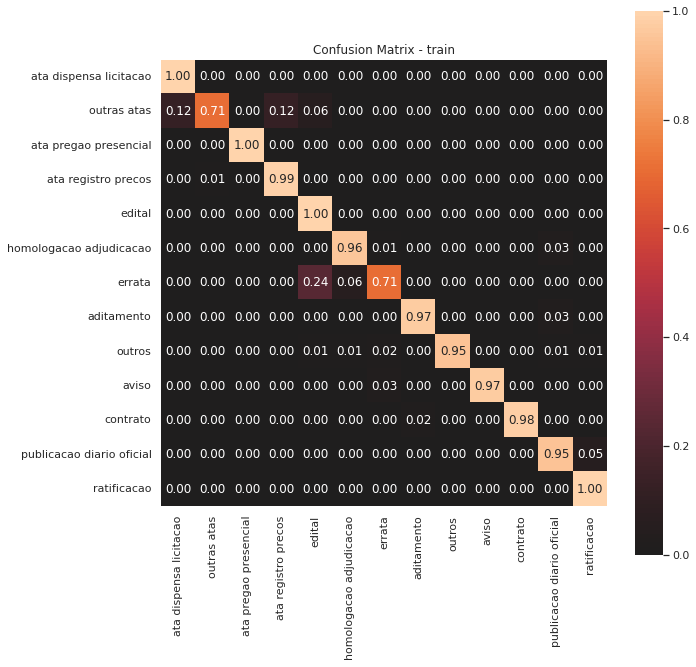

Train:
 loss 0.089, accuracy 0.973, F1-Macro 0.939, F1-Weighted 0.973
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12}
{0: 'ata dispensa licitacao', 1: 'outras atas', 2: 'ata pregao presencial', 3: 'ata registro precos', 4: 'edital', 5: 'homologacao adjudicacao', 6: 'errata', 7: 'aditamento', 8: 'outros', 9: 'aviso', 10: 'contrato', 11: 'publicacao diario oficial', 12: 'ratificacao'}


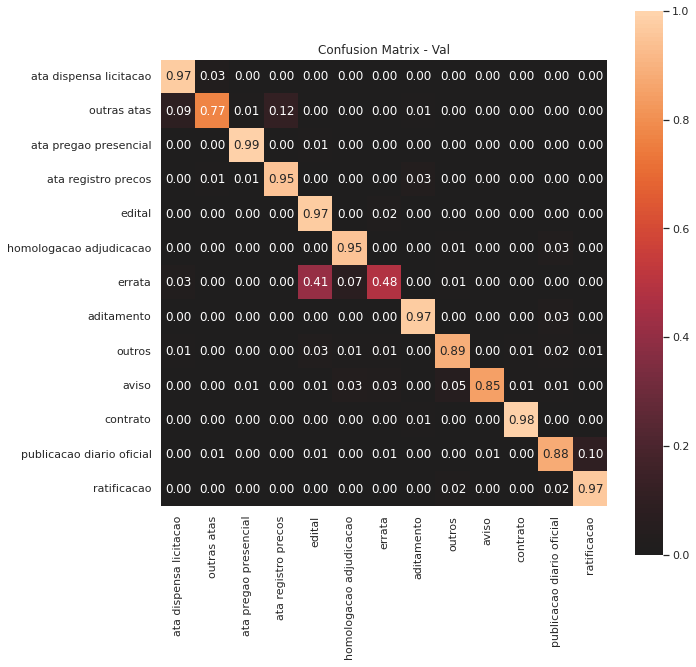

Val:
 loss 0.243, accuracy 0.941, F1-Macro 0.889, F1-Weighted 0.941
{4, 6, 8, 9, 12}
{0: 'ata dispensa licitacao', 1: 'outras atas', 2: 'ata pregao presencial', 3: 'ata registro precos', 4: 'edital', 5: 'homologacao adjudicacao', 6: 'errata', 7: 'aditamento', 8: 'outros', 9: 'aviso', 10: 'contrato', 11: 'publicacao diario oficial', 12: 'ratificacao'}


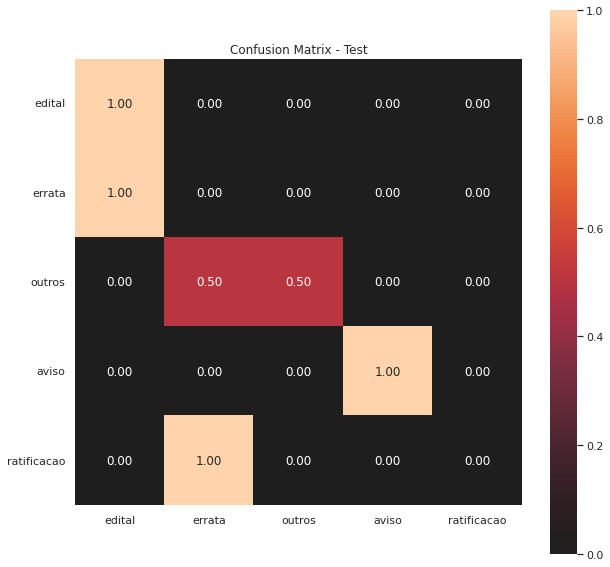

Test:
 loss 0.270, accuracy 0.967, F1-Macro 0.529, F1-Weighted 0.957
**** VALIDATION CITY: ribeirao_vermelho****


/dados01/workspace/ufmg.f01dcc/py37/lib/python3.7/site-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/dados01/workspace/ufmg.f01dcc/py37/lib/python3.7/site-packages/ipykernel_launcher.py:27: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/dados01/workspace/ufmg.f01dcc/py37/lib/python3.7/site-packages/ipykernel_launcher.py:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to 

==================== Epoch: 1 ====================
Train:
 loss 1.374, accuracy 0.594, F1-Macro 0.324, F1-Weighted 0.539
Val:
 loss 0.728, accuracy 0.814, F1-Macro 0.608, F1-Weighted 0.784 

==================== Epoch: 2 ====================
Train:
 loss 0.567, accuracy 0.865, F1-Macro 0.724, F1-Weighted 0.851
Val:
 loss 0.383, accuracy 0.907, F1-Macro 0.791, F1-Weighted 0.903 

==================== Epoch: 3 ====================
Train:
 loss 0.373, accuracy 0.904, F1-Macro 0.803, F1-Weighted 0.895
Val:
 loss 0.400, accuracy 0.872, F1-Macro 0.707, F1-Weighted 0.860 

==================== Epoch: 4 ====================
Train:
 loss 0.292, accuracy 0.923, F1-Macro 0.826, F1-Weighted 0.915
Val:
 loss 0.275, accuracy 0.929, F1-Macro 0.839, F1-Weighted 0.920 

==================== Epoch: 5 ====================
Train:
 loss 0.202, accuracy 0.945, F1-Macro 0.869, F1-Weighted 0.938
Val:
 loss 0.258, accuracy 0.939, F1-Macro 0.863, F1-Weighted 0.934 

==================== Epoch: 6 ===============

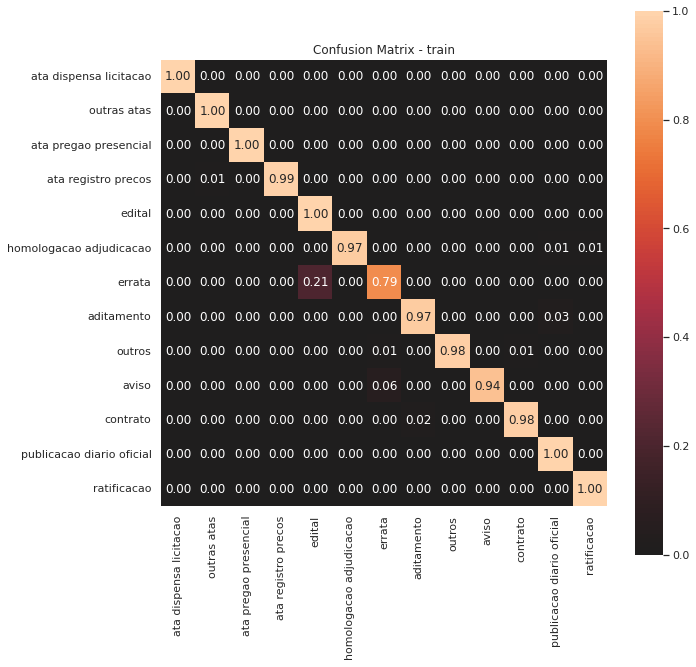

Train:
 loss 0.062, accuracy 0.984, F1-Macro 0.967, F1-Weighted 0.985
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12}
{0: 'ata dispensa licitacao', 1: 'outras atas', 2: 'ata pregao presencial', 3: 'ata registro precos', 4: 'edital', 5: 'homologacao adjudicacao', 6: 'errata', 7: 'aditamento', 8: 'outros', 9: 'aviso', 10: 'contrato', 11: 'publicacao diario oficial', 12: 'ratificacao'}


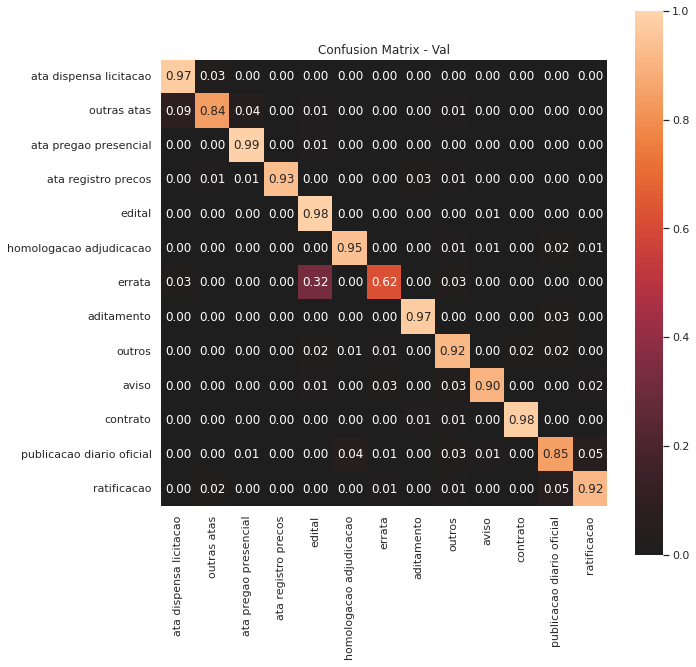

Val:
 loss 0.217, accuracy 0.950, F1-Macro 0.909, F1-Weighted 0.950
{0, 4, 6, 8, 9}
{0: 'ata dispensa licitacao', 1: 'outras atas', 2: 'ata pregao presencial', 3: 'ata registro precos', 4: 'edital', 5: 'homologacao adjudicacao', 6: 'errata', 7: 'aditamento', 8: 'outros', 9: 'aviso', 10: 'contrato', 11: 'publicacao diario oficial', 12: 'ratificacao'}


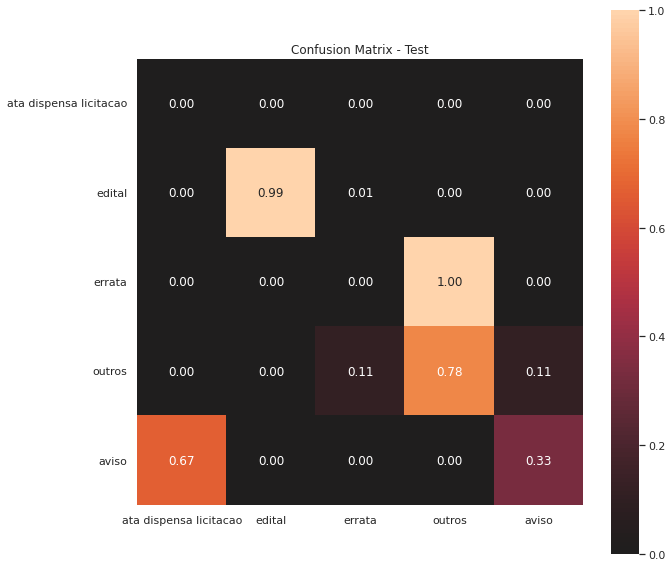

Test:
 loss 0.190, accuracy 0.959, F1-Macro 0.435, F1-Weighted 0.963
**** VALIDATION CITY: olaria****


/dados01/workspace/ufmg.f01dcc/py37/lib/python3.7/site-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/dados01/workspace/ufmg.f01dcc/py37/lib/python3.7/site-packages/ipykernel_launcher.py:27: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/dados01/workspace/ufmg.f01dcc/py37/lib/python3.7/site-packages/ipykernel_launcher.py:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to 

==================== Epoch: 1 ====================
Train:
 loss 1.520, accuracy 0.568, F1-Macro 0.300, F1-Weighted 0.515
Val:
 loss 0.812, accuracy 0.772, F1-Macro 0.478, F1-Weighted 0.743 

==================== Epoch: 2 ====================
Train:
 loss 0.528, accuracy 0.847, F1-Macro 0.659, F1-Weighted 0.834
Val:
 loss 0.417, accuracy 0.884, F1-Macro 0.719, F1-Weighted 0.869 

==================== Epoch: 3 ====================
Train:
 loss 0.339, accuracy 0.909, F1-Macro 0.782, F1-Weighted 0.901
Val:
 loss 0.343, accuracy 0.907, F1-Macro 0.803, F1-Weighted 0.899 

==================== Epoch: 4 ====================
Train:
 loss 0.238, accuracy 0.942, F1-Macro 0.847, F1-Weighted 0.935
Val:
 loss 0.275, accuracy 0.930, F1-Macro 0.837, F1-Weighted 0.924 

==================== Epoch: 5 ====================
Train:
 loss 0.192, accuracy 0.951, F1-Macro 0.852, F1-Weighted 0.944
Val:
 loss 0.316, accuracy 0.911, F1-Macro 0.789, F1-Weighted 0.901 

==================== Epoch: 6 ===============

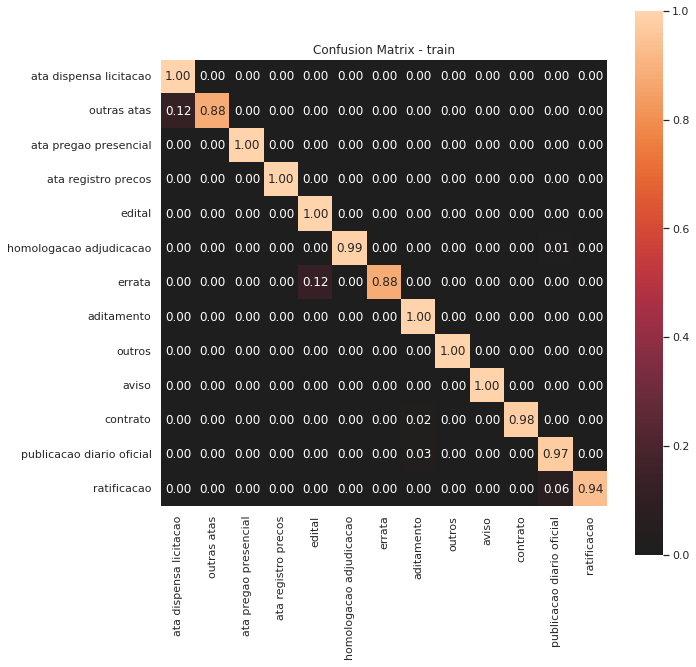

Train:
 loss 0.033, accuracy 0.989, F1-Macro 0.975, F1-Weighted 0.989
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12}
{0: 'ata dispensa licitacao', 1: 'outras atas', 2: 'ata pregao presencial', 3: 'ata registro precos', 4: 'edital', 5: 'homologacao adjudicacao', 6: 'errata', 7: 'aditamento', 8: 'outros', 9: 'aviso', 10: 'contrato', 11: 'publicacao diario oficial', 12: 'ratificacao'}


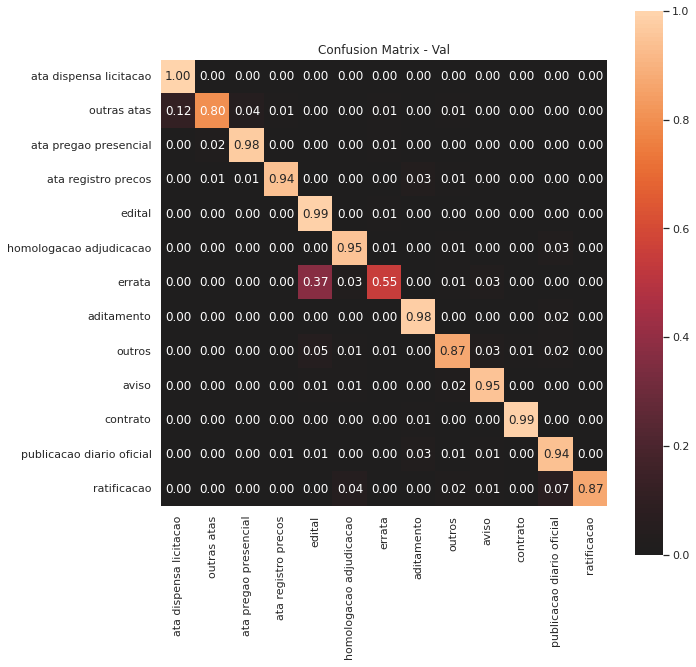

Val:
 loss 0.228, accuracy 0.952, F1-Macro 0.911, F1-Weighted 0.951
{8, 9, 4, 6}
{0: 'ata dispensa licitacao', 1: 'outras atas', 2: 'ata pregao presencial', 3: 'ata registro precos', 4: 'edital', 5: 'homologacao adjudicacao', 6: 'errata', 7: 'aditamento', 8: 'outros', 9: 'aviso', 10: 'contrato', 11: 'publicacao diario oficial', 12: 'ratificacao'}


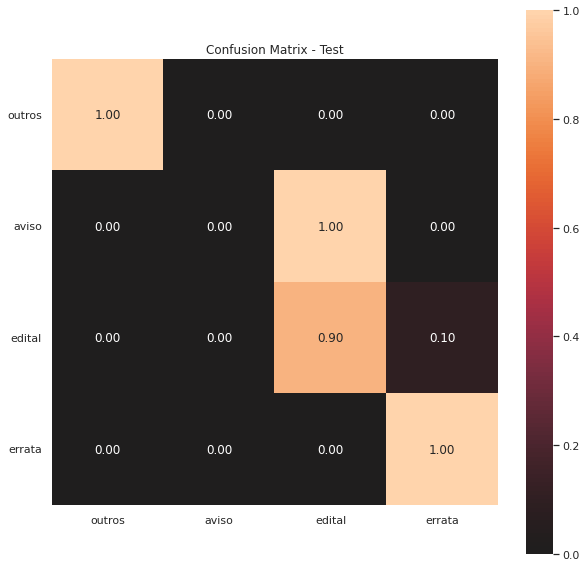

Test:
 loss 5.673, accuracy 0.429, F1-Macro 0.582, F1-Weighted 0.282


In [24]:
def main(num_epochs, num_classes):
    set_seed(SEED)
        
    #load_data(df_data)
    config = {
        "embedding_dim": 600,
        "num_layers": 3,
        "dropout": 0.2,
        "lr": 0.001,
        "num_terms": 1000,
        #"num_terms": 1000,
        "batch_size": 24,
        "num_epochs": num_epochs,
        "num_classe": None,
        "vocab_size": None, 
        "patience": 5
    }
    
    #df_data = pd.read_csv("./lstm_data/preprocessed_data_v2.csv") 
    #df_data = pd.read_csv("./lstm_data/preprocessed_data_preprocess_unity.csv")
    #df_data = pd.read_csv("./lstm_data/preprocessed_data_preprocess_simples.csv")
    #df_data = pd.read_csv("./lstm_data/preprocessed_data_preprocess_completo.csv")
    #df_data = pd.read_csv("./lstm_data/preprocessed_data_preprocess_simple-unity.csv")
    df_data = pd.read_csv("./lstm_data/preprocessed_data_preprocess_completo-unity.csv")
        
    labels_dict = dict(df_data[['label_int', 'label']].drop_duplicates().values)

    # usa a classe e a cidade para criar uma classe só
    df_data['multi_label'] = df_data['label'] + '' + df_data['city']
    # casos em que classes aparecem só uma vez por município (vai ter só uma nova ocorrência da classe nova)
    tmp = df_data.groupby('multi_label').size().reset_index(name='size')
    unique_classes = tmp.loc[tmp['size'] == 1, 'multi_label'].values
    
    cities = df_data['city'].unique()
    
    for city in cities:
        print(f'**** VALIDATION CITY: {city}****')
        # todos os dados iniciam como treino
        df_data['fold'] = 'train'
        
        # uma cidade como teste
        city_index = df_data[df_data['city'] == city].index
        df_data.at[city_index, 'fold'] = 'test'
        
        # "classes unicas" vão pro conjunto de validação
        df_data.loc[(df_data['multi_label'].isin(unique_classes)) & (df_data['fold'] == 'train'), 'fold'] = 'val'
        
        # labels do conjunto de treino
        df_labels = df_data.loc[df_data['fold'] == 'train']
        df_labels = pd.concat([pd.get_dummies(df_labels['city']), pd.get_dummies(df_labels['label'])], axis=1)
        
        # faz o split extratificado por cidade e classe
        train, _, val, _ = train_test_split(
            df_data.loc[df_data['fold'] == 'train'],
            df_data.loc[df_data['fold'] == 'train', 'multi_label'], 
            stratify = df_data.loc[df_data['fold'] == 'train', 'multi_label'],
            test_size = 0.2, 
            random_state=SEED)
        
        df_data.loc[val.index, 'fold'] = 'val'
        
        df_data, vocab_size, vocab2index = encode_data(df_data, config)
        
        config.update({
            "num_classes": df_data['label'].nunique(),
            "vocab_size": vocab_size
        })
    
        data_loaders = data_load(config, df_data)
    
        embedding_matrix=create_embedding_matrix(vocab2index,dimension=600)
    
        best_model = train_model(city, config, checkpoint_dir="./lstm_data/models/", data_loaders=data_loaders, embedding_matrix=embedding_matrix)
    
        device = "cpu"
        if torch.cuda.is_available():
            device = "cuda:0"
        best_model.to(device)
    
        print("="*20, "BEST MODEL", "="*20)
        train_metrics = eval_model(city, best_model, data_loaders["train"], fold = "train", labels_dict = labels_dict, device=device)
        print("Train:\n loss %.3f, accuracy %.3f, F1-Macro %.3f, F1-Weighted %.3f" % (
            train_metrics[0], train_metrics[1], train_metrics[2], train_metrics[3]))
    
        val_metrics = eval_model(city, best_model, data_loaders["val"], fold = "Val", labels_dict = labels_dict, device=device)
        print("Val:\n loss %.3f, accuracy %.3f, F1-Macro %.3f, F1-Weighted %.3f" % (
            val_metrics[0], val_metrics[1], val_metrics[2], val_metrics[3]))

        test_metrics = eval_model(city, best_model, data_loaders["test"], fold = "Test", labels_dict = labels_dict, device=device)
        print("Test:\n loss %.3f, accuracy %.3f, F1-Macro %.3f, F1-Weighted %.3f" % (
            test_metrics[0], test_metrics[1], test_metrics[2], test_metrics[3]))
    
if __name__ == "__main__":
    # You can change the number of GPUs per trial here:
    main(num_epochs=40, num_classes=13)

# Pré-processamento F03

Cristais
Train:
 loss 0.075, accuracy 0.977, F1-Macro 0.956, F1-Weighted 0.977
Val:
 loss 0.277, accuracy 0.937, F1-Macro 0.880, F1-Weighted 0.936
Test:
 loss 1.648, accuracy 0.471, F1-Macro 0.333, F1-Weighted 0.464
 
 Pirapetinga
 Train:
 loss 0.075, accuracy 0.977, F1-Macro 0.956, F1-Weighted 0.977
 Val:
 loss 0.277, accuracy 0.937, F1-Macro 0.880, F1-Weighted 0.936
 Test:
 loss 1.648, accuracy 0.471, F1-Macro 0.333, F1-Weighted 0.464

São Bento Abade
Train:
 loss 0.060, accuracy 0.984, F1-Macro 0.961, F1-Weighted 0.984
Val:
 loss 0.195, accuracy 0.955, F1-Macro 0.911, F1-Weighted 0.955
Test:
 loss 2.073, accuracy 0.384, F1-Macro 0.300, F1-Weighted 0.448

Coqueiral
Train:
 loss 0.139, accuracy 0.964, F1-Macro 0.893, F1-Weighted 0.959
Val:
 loss 0.267, accuracy 0.934, F1-Macro 0.868, F1-Weighted 0.930
Test:
 loss 1.964, accuracy 0.564, F1-Macro 0.204, F1-Weighted 0.500

Passa Vinte
Train:
 loss 0.031, accuracy 0.990, F1-Macro 0.980, F1-Weighted 0.990
Val:
 loss 0.180, accuracy 0.961, F1-Macro 0.931, F1-Weighted 0.960
Test:
 loss 1.282, accuracy 0.726, F1-Macro 0.415, F1-Weighted 0.751

Itamarati
Train:
 loss 0.051, accuracy 0.987, F1-Macro 0.977, F1-Weighted 0.987
Val:
 loss 0.245, accuracy 0.944, F1-Macro 0.897, F1-Weighted 0.945
Test:
 loss 2.302, accuracy 0.546, F1-Macro 0.354, F1-Weighted 0.438

Arantina
Train:
 loss 0.056, accuracy 0.982, F1-Macro 0.969, F1-Weighted 0.982
Val:
 loss 0.282, accuracy 0.933, F1-Macro 0.891, F1-Weighted 0.933
Test:
 loss 3.257, accuracy 0.049, F1-Macro 0.036, F1-Weighted 0.087

Ijaci
Train:
 loss 0.094, accuracy 0.974, F1-Macro 0.955, F1-Weighted 0.974
Val:
 loss 0.229, accuracy 0.948, F1-Macro 0.908, F1-Weighted 0.947
Test:
 loss 0.634, accuracy 0.917, F1-Macro 0.364, F1-Weighted 0.890

Ribeirão Vermelho
Train:
 loss 0.069, accuracy 0.983, F1-Macro 0.969, F1-Weighted 0.982
Val:
 loss 0.239, accuracy 0.946, F1-Macro 0.909, F1-Weighted 0.946
Test:
 loss 0.313, accuracy 0.948, F1-Macro 0.526, F1-Weighted 0.948

Olaria
Train:
 loss 0.081, accuracy 0.978, F1-Macro 0.948, F1-Weighted 0.976
Val:
 loss 0.225, accuracy 0.946, F1-Macro 0.894, F1-Weighted 0.944
Test:
 loss 2.486, accuracy 0.429, F1-Macro 0.556, F1-Weighted 0.282


# Resultados com pré-processamento - removendo unidades de medida e entidade
Cristais
Train:
 loss 0.074, accuracy 0.973, F1-Macro 0.896, F1-Weighted 0.971
Val:
 loss 0.262, accuracy 0.929, F1-Macro 0.801, F1-Weighted 0.925
Test:
 loss 3.084, accuracy 0.229, F1-Macro 0.098, F1-Weighted 0.282

Pirapetinga
Train:
 loss 0.114, accuracy 0.970, F1-Macro 0.927, F1-Weighted 0.968
Val:
 loss 0.274, accuracy 0.931, F1-Macro 0.851, F1-Weighted 0.926
Test:
 loss 3.457, accuracy 0.433, F1-Macro 0.205, F1-Weighted 0.343

São bento Abade
Train:
 loss 0.082, accuracy 0.977, F1-Macro 0.943, F1-Weighted 0.978
Val:
 loss 0.221, accuracy 0.951, F1-Macro 0.903, F1-Weighted 0.951
Test:
 loss 1.991, accuracy 0.502, F1-Macro 0.210, F1-Weighted 0.528

Coqueiral
Train:
 loss 0.070, accuracy 0.983, F1-Macro 0.959, F1-Weighted 0.983
Val:
 loss 0.254, accuracy 0.932, F1-Macro 0.838, F1-Weighted 0.931
Test:
 loss 3.537, accuracy 0.419, F1-Macro 0.194, F1-Weighted 0.372

Passa Vinte
Train:
 loss 0.026, accuracy 0.992, F1-Macro 0.982, F1-Weighted 0.992
Val:
 loss 0.193, accuracy 0.955, F1-Macro 0.927, F1-Weighted 0.954
Test:
 loss 1.131, accuracy 0.756, F1-Macro 0.296, F1-Weighted 0.741

Itamarati
Train:
 loss 0.140, accuracy 0.957, F1-Macro 0.885, F1-Weighted 0.951
Val:
 loss 0.267, accuracy 0.930, F1-Macro 0.835, F1-Weighted 0.924
Test:
 loss 4.168, accuracy 0.272, F1-Macro 0.128, F1-Weighted 0.326

Arantina
Train:
 loss 0.046, accuracy 0.984, F1-Macro 0.955, F1-Weighted 0.983
Val:
 loss 0.259, accuracy 0.935, F1-Macro 0.872, F1-Weighted 0.932
Test:
 loss 3.259, accuracy 0.116, F1-Macro 0.086, F1-Weighted 0.156

Ijaci
Train:
 loss 0.082, accuracy 0.973, F1-Macro 0.944, F1-Weighted 0.973
Val:
 loss 0.234, accuracy 0.940, F1-Macro 0.893, F1-Weighted 0.939
Test:
 loss 0.319, accuracy 0.937, F1-Macro 0.373, F1-Weighted 0.941

Ribeirão Vermelho
Train:
 loss 0.032, accuracy 0.990, F1-Macro 0.975, F1-Weighted 0.990
Val:
 loss 0.209, accuracy 0.954, F1-Macro 0.919, F1-Weighted 0.954
Test:
 loss 0.093, accuracy 0.965, F1-Macro 0.623, F1-Weighted 0.971

Olaria
Train:
 loss 0.079, accuracy 0.978, F1-Macro 0.951, F1-Weighted 0.978
Val:
 loss 0.228, accuracy 0.943, F1-Macro 0.889, F1-Weighted 0.941
Test:
 loss 4.222, accuracy 0.393, F1-Macro 0.379, F1-Weighted 0.260
Test:
 loss 4.222, accuracy 0.393, F1-Macro 0.379, F1-Weighted 0.260

# Resultados do pré-processamento - simples

Cristais

Train:
 loss 0.088, accuracy 0.974, F1-Macro 0.917, F1-Weighted 0.973
Val:
 loss 0.238, accuracy 0.942, F1-Macro 0.873, F1-Weighted 0.940
Test:
 loss 2.911, accuracy 0.588, F1-Macro 0.298, F1-Weighted 0.563

Pirapetinga
Train:
 loss 0.108, accuracy 0.971, F1-Macro 0.937, F1-Weighted 0.971
Val:
 loss 0.242, accuracy 0.944, F1-Macro 0.892, F1-Weighted 0.944
Test:
 loss 3.376, accuracy 0.380, F1-Macro 0.259, F1-Weighted 0.330

São Bento Ábade
Train:
 loss 0.048, accuracy 0.985, F1-Macro 0.962, F1-Weighted 0.985
Val:
 loss 0.201, accuracy 0.956, F1-Macro 0.908, F1-Weighted 0.955
Test:
 loss 2.243, accuracy 0.546, F1-Macro 0.175, F1-Weighted 0.515

Coqueiral
Train:
 loss 0.114, accuracy 0.969, F1-Macro 0.908, F1-Weighted 0.968
Val:
 loss 0.295, accuracy 0.933, F1-Macro 0.831, F1-Weighted 0.930
Test:
 loss 4.817, accuracy 0.272, F1-Macro 0.091, F1-Weighted 0.160

Passa Vinte
Train:
 loss 0.094, accuracy 0.969, F1-Macro 0.928, F1-Weighted 0.967
Val:
 loss 0.237, accuracy 0.944, F1-Macro 0.881, F1-Weighted 0.941
Test:
 loss 1.205, accuracy 0.802, F1-Macro 0.286, F1-Weighted 0.786

Itamarati
Train:
 loss 0.112, accuracy 0.967, F1-Macro 0.918, F1-Weighted 0.966
Val:
 loss 0.287, accuracy 0.936, F1-Macro 0.868, F1-Weighted 0.934
Test:
 loss 3.810, accuracy 0.440, F1-Macro 0.090, F1-Weighted 0.271

Arantina
Train:
 loss 0.065, accuracy 0.983, F1-Macro 0.965, F1-Weighted 0.983
Val:
 loss 0.229, accuracy 0.951, F1-Macro 0.909, F1-Weighted 0.950
Test:
 loss 1.780, accuracy 0.311, F1-Macro 0.222, F1-Weighted 0.430

Ijaci
Train:
 loss 0.165, accuracy 0.951, F1-Macro 0.887, F1-Weighted 0.948
Val:
 loss 0.284, accuracy 0.927, F1-Macro 0.834, F1-Weighted 0.921
Test:
 loss 0.704, accuracy 0.776, F1-Macro 0.321, F1-Weighted 0.821

Ribeirão Vermelho
Train:
 loss 0.100, accuracy 0.968, F1-Macro 0.937, F1-Weighted 0.967
Val:
 loss 0.198, accuracy 0.951, F1-Macro 0.903, F1-Weighted 0.950
Test:
 loss 0.299, accuracy 0.965, F1-Macro 0.428, F1-Weighted 0.974

Olaria
Train:
 loss 0.086, accuracy 0.978, F1-Macro 0.949, F1-Weighted 0.977
Val:
 loss 0.226, accuracy 0.950, F1-Macro 0.891, F1-Weighted 0.948
Test:
 loss 3.381, accuracy 0.393, F1-Macro 0.248, F1-Weighted 0.228

# Resultados do pré-processamento - simples + removendo unidades de medida e entidade

Cristais

Train:
 loss 0.083, accuracy 0.978, F1-Macro 0.921, F1-Weighted 0.978
Val:
 loss 0.238, accuracy 0.940, F1-Macro 0.838, F1-Weighted 0.939
Test:
 loss 4.075, accuracy 0.398, F1-Macro 0.257, F1-Weighted 0.384

Pirapetinga
Train:
 loss 0.067, accuracy 0.983, F1-Macro 0.963, F1-Weighted 0.982
Val:
 loss 0.238, accuracy 0.945, F1-Macro 0.896, F1-Weighted 0.945
Test:
 loss 3.104, accuracy 0.347, F1-Macro 0.282, F1-Weighted 0.263

São Bento Abade
Train:
 loss 0.076, accuracy 0.976, F1-Macro 0.938, F1-Weighted 0.975
Val:
 loss 0.204, accuracy 0.953, F1-Macro 0.895, F1-Weighted 0.951
Test:
 loss 1.150, accuracy 0.738, F1-Macro 0.374, F1-Weighted 0.712

Coqueiral
Train:
 loss 0.086, accuracy 0.976, F1-Macro 0.938, F1-Weighted 0.975
Val:
 loss 0.259, accuracy 0.939, F1-Macro 0.850, F1-Weighted 0.937
Test:
 loss 4.137, accuracy 0.282, F1-Macro 0.145, F1-Weighted 0.286

Passa Vinte
Train:
 loss 0.041, accuracy 0.990, F1-Macro 0.977, F1-Weighted 0.990
Val:
 loss 0.192, accuracy 0.957, F1-Macro 0.919, F1-Weighted 0.956
Test:
 loss 1.083, accuracy 0.821, F1-Macro 0.408, F1-Weighted 0.810

Itamarati
Train:
 loss 0.064, accuracy 0.985, F1-Macro 0.969, F1-Weighted 0.985
Val:
 loss 0.216, accuracy 0.945, F1-Macro 0.891, F1-Weighted 0.944
Test:
 loss 3.021, accuracy 0.360, F1-Macro 0.192, F1-Weighted 0.352

Arantina
Train:
 loss 0.148, accuracy 0.963, F1-Macro 0.920, F1-Weighted 0.962
Val:
 loss 0.260, accuracy 0.940, F1-Macro 0.880, F1-Weighted 0.938
Test:
 loss 0.128, accuracy 0.966, F1-Macro 0.496, F1-Weighted 0.978

Ijaci
Train:
 loss 0.071, accuracy 0.977, F1-Macro 0.949, F1-Weighted 0.977
Val:
 loss 0.199, accuracy 0.951, F1-Macro 0.903, F1-Weighted 0.949
Test:
 loss 0.334, accuracy 0.940, F1-Macro 0.430, F1-Weighted 0.929

Ribeirão Vermelho
Train:
 loss 0.060, accuracy 0.984, F1-Macro 0.965, F1-Weighted 0.983
Val:
 loss 0.180, accuracy 0.957, F1-Macro 0.914, F1-Weighted 0.956
Test:
 loss 0.089, accuracy 0.971, F1-Macro 0.510, F1-Weighted 0.967

Olaria
Train:
 loss 0.080, accuracy 0.979, F1-Macro 0.936, F1-Weighted 0.976
Val:
 loss 0.205, accuracy 0.956, F1-Macro 0.904, F1-Weighted 0.954
Test:
 loss 3.997, accuracy 0.464, F1-Macro 0.643, F1-Weighted 0.311


# Resultados do pré-processamento - completo
Cristais
Train:
 loss 0.142, accuracy 0.961, F1-Macro 0.882, F1-Weighted 0.958
Val:
 loss 0.269, accuracy 0.932, F1-Macro 0.838, F1-Weighted 0.927
Test:
 loss 2.483, accuracy 0.454, F1-Macro 0.220, F1-Weighted 0.448

Pirapetinga
Train:
 loss 0.105, accuracy 0.973, F1-Macro 0.943, F1-Weighted 0.973
Val:
 loss 0.249, accuracy 0.944, F1-Macro 0.894, F1-Weighted 0.943
Test:
 loss 2.631, accuracy 0.507, F1-Macro 0.289, F1-Weighted 0.435


São Bento Ábade
Train:
 loss 0.059, accuracy 0.984, F1-Macro 0.964, F1-Weighted 0.984
Val:
 loss 0.209, accuracy 0.955, F1-Macro 0.914, F1-Weighted 0.955
Test:
 loss 4.306, accuracy 0.341, F1-Macro 0.197, F1-Weighted 0.422

Coqueiral
Train:
 loss 0.125, accuracy 0.968, F1-Macro 0.910, F1-Weighted 0.965
Val:
 loss 0.274, accuracy 0.938, F1-Macro 0.843, F1-Weighted 0.933
Test:
 loss 3.858, accuracy 0.452, F1-Macro 0.169, F1-Weighted 0.356

Passa Vinte
Train:
 loss 0.129, accuracy 0.968, F1-Macro 0.916, F1-Weighted 0.964
Val:
 loss 0.213, accuracy 0.952, F1-Macro 0.891, F1-Weighted 0.946
Test:
 loss 1.508, accuracy 0.702, F1-Macro 0.311, F1-Weighted 0.696



Itamarati

Train:
 loss 0.126, accuracy 0.960, F1-Macro 0.887, F1-Weighted 0.958
Val:
 loss 0.284, accuracy 0.924, F1-Macro 0.811, F1-Weighted 0.919
Test:
 loss 3.550, accuracy 0.445, F1-Macro 0.288, F1-Weighted 0.297

Arantina
Train:
 loss 0.161, accuracy 0.953, F1-Macro 0.889, F1-Weighted 0.949
Val:
 loss 0.272, accuracy 0.929, F1-Macro 0.851, F1-Weighted 0.924
Test:
 loss 2.990, accuracy 0.162, F1-Macro 0.149, F1-Weighted 0.206

Ijaci
Train:
 loss 0.106, accuracy 0.969, F1-Macro 0.925, F1-Weighted 0.967
Val:
 loss 0.246, accuracy 0.945, F1-Macro 0.891, F1-Weighted 0.943
Test:
 loss 0.352, accuracy 0.965, F1-Macro 0.395, F1-Weighted 0.951


Ribeirão Vermelho
Train:
 loss 0.055, accuracy 0.984, F1-Macro 0.970, F1-Weighted 0.984
Val:
 loss 0.205, accuracy 0.956, F1-Macro 0.916, F1-Weighted 0.955
Test:
 loss 0.133, accuracy 0.977, F1-Macro 0.548, F1-Weighted 0.974

Olaria
Train:
 loss 0.144, accuracy 0.963, F1-Macro 0.898, F1-Weighted 0.958
Val:
 loss 0.256, accuracy 0.933, F1-Macro 0.839, F1-Weighted 0.926
Test:
 loss 4.230, accuracy 0.464, F1-Macro 0.643, F1-Weighted 0.311


# Resultados do pré-processamento - Completo + removendo unidades de medida e entidade

Cristais
Train:
 loss 0.112, accuracy 0.970, F1-Macro 0.844, F1-Weighted 0.966
Val:
 loss 0.262, accuracy 0.929, F1-Macro 0.776, F1-Weighted 0.924
Test:
 loss 2.610, accuracy 0.415, F1-Macro 0.268, F1-Weighted 0.443

Pirapetinga
Train:
 loss 0.078, accuracy 0.982, F1-Macro 0.963, F1-Weighted 0.981
Val:
 loss 0.267, accuracy 0.942, F1-Macro 0.897, F1-Weighted 0.941
Test:
 loss 3.965, accuracy 0.470, F1-Macro 0.273, F1-Weighted 0.413

São Bento Abade
Train:
 loss 0.097, accuracy 0.976, F1-Macro 0.941, F1-Weighted 0.976
Val:
 loss 0.223, accuracy 0.951, F1-Macro 0.898, F1-Weighted 0.950
Test:
 loss 1.416, accuracy 0.651, F1-Macro 0.262, F1-Weighted 0.607


Coqueiral
Train:
 loss 0.100, accuracy 0.970, F1-Macro 0.920, F1-Weighted 0.968
Val:
 loss 0.227, accuracy 0.945, F1-Macro 0.867, F1-Weighted 0.941
Test:
 loss 2.273, accuracy 0.425, F1-Macro 0.153, F1-Weighted 0.379
 
 Passa Vinte
 Train:
 loss 0.074, accuracy 0.979, F1-Macro 0.954, F1-Weighted 0.978
 Val:
 loss 0.183, accuracy 0.958, F1-Macro 0.918, F1-Weighted 0.957
 Test:
 loss 1.894, accuracy 0.423, F1-Macro 0.135, F1-Weighted 0.458
 
 Itamarati
 Train:
 loss 0.115, accuracy 0.970, F1-Macro 0.926, F1-Weighted 0.967
 Val:
 loss 0.257, accuracy 0.937, F1-Macro 0.863, F1-Weighted 0.933
 Test:
 loss 3.661, accuracy 0.339, F1-Macro 0.286, F1-Weighted 0.291
 
Arantina

Train:
 loss 0.054, accuracy 0.981, F1-Macro 0.965, F1-Weighted 0.982
Val:
 loss 0.224, accuracy 0.943, F1-Macro 0.907, F1-Weighted 0.944
Test:
 loss 4.349, accuracy 0.082, F1-Macro 0.103, F1-Weighted 0.141


Ijaci
Train:
 loss 0.089, accuracy 0.973, F1-Macro 0.939, F1-Weighted 0.973
Val:
 loss 0.243, accuracy 0.941, F1-Macro 0.889, F1-Weighted 0.941
Test:
 loss 0.270, accuracy 0.967, F1-Macro 0.529, F1-Weighted 0.957


Ribeirão Vermelho
Train:
 loss 0.062, accuracy 0.984, F1-Macro 0.967, F1-Weighted 0.985
Val:
 loss 0.217, accuracy 0.950, F1-Macro 0.909, F1-Weighted 0.950
Test:
 loss 0.190, accuracy 0.959, F1-Macro 0.435, F1-Weighted 0.963

Olaria
Train:
 loss 0.033, accuracy 0.989, F1-Macro 0.975, F1-Weighted 0.989
Val:
 loss 0.228, accuracy 0.952, F1-Macro 0.911, F1-Weighted 0.951
Test:
 loss 5.673, accuracy 0.429, F1-Macro 0.582, F1-Weighted 0.282



# Todos documentos
### 21 classes
==================== BEST MODEL ====================<br/>
Val:<br/>
 loss 0.127, accuracy 0.973, F1-Macro 0.936, F1-Weighted 0.972<br/>
Test:<br/>
 loss 0.139, accuracy 0.966, F1-Macro 0.942, F1-Weighted 0.966<br/>
 
### 13 classes
==================== BEST MODEL ====================<br/>
Val:<br/>
 loss 0.118, accuracy 0.970, F1-Macro 0.953, F1-Weighted 0.970<br/>
Test:<br/>
 loss 0.169, accuracy 0.970, F1-Macro 0.955, F1-Weighted 0.970<br/>

# 10% dos documentos dos municípios foram usados para treinamento
# Val: Pirapetinga
# Test: São Bento Abade
 
### 13 classes
==================== BEST MODEL ====================<br/>
Train:<br/>
 loss 0.121, accuracy 0.966, F1-Macro 0.930, F1-Weighted 0.966<br/>
Val:<br/>
 loss 0.391, accuracy 0.888, F1-Macro 0.670, F1-Weighted 0.892<br/>
Test:<br/>
 loss 1.000, accuracy 0.782, F1-Macro 0.476, F1-Weighted 0.766<br/>